
<p align="center">
    <img src="mosef.png" alt="MOSEF Logo" width="300">
</p>

</p>

<a href="https://linkedin.com/in/lucasvazelle">Vazelle Lucas  </a> $\cdot$ 
<a href="https://www.linkedin.com/in/mariam-tarverdian">Tarverdian Mariam </a> $\cdot$ 
<a href="https://github.com/lucasvazelle/MOSEF-Bank-Churn-Prediction-VAZELLE-TAVERDIAN"> Projet git </a> $\cdot$ 2024-2025, MOSEF 



---


- [Projet Kaggel ](https://www.kaggle.com/competitions/mosef-bank-churn-prediction/)


#!pip install pandas numpy seaborn statsmodels matplotlib scikit-learn 

In [109]:
# Importer les dépendances
import pandas as pd
import numpy as np
import seaborn as sns

# Preprocessing
#from sklearn.preprocessing import RobustScaler
import statsmodels.api as sm
import matplotlib.pyplot as plt


# Modèles de machine learning
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

# Modèle de boosting
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
#from catboost import CatBoostClassifier

# Pour le stacking
from sklearn.linear_model import LogisticRegression, ElasticNetCV
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.base import clone

# Explicabilité 
from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score
#import shap


# 0. Import data <a class="anchor" id="Introduction"></a>
---


In [82]:

train_data_path = 'data/train.csv'
test_data_path = 'data/test.csv'

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print("Training Data:")
display(train.head())

print("Testing Data:")
display(test.head())

train.isnull().sum() # pas de na

train.dtypes # pas de surprises pour les types


Training Data:


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15713774.0,Hsieh,683.0,Germany,Male,49.0,7.0,123837.86,2.0,1.0,1.0,138700.75,1.0
1,1,15682533.0,Hs?eh,608.0,France,Female,30.0,10.0,0.00,2.0,1.0,1.0,146723.72,0.0
2,2,15791550.0,Tsou,539.0,France,Female,32.0,8.0,0.00,1.0,1.0,1.0,94873.60,0.0
3,3,15762762.0,Chiawuotu,530.0,Spain,Female,39.0,8.0,0.00,2.0,0.0,0.0,177896.93,0.0
4,4,15756475.0,Nnamdi,613.0,France,Female,45.0,10.0,0.00,2.0,1.0,1.0,116748.14,0.0


Testing Data:


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15000,15797736.0,Chikwendu,591.0,Germany,Female,32.0,2.0,106881.50,2.0,1.0,0.0,122810.53
1,15001,15676515.0,Lai,553.0,Spain,Male,37.0,2.0,0.00,2.0,1.0,0.0,63736.17
2,15002,15701291.0,Folliero,646.0,France,Female,29.0,7.0,0.00,2.0,1.0,0.0,121866.87
3,15003,15594812.0,Trevisani,603.0,Germany,Male,49.0,8.0,131394.56,1.0,0.0,1.0,147059.28
4,15004,15791321.0,Ch'ien,645.0,Spain,Female,39.0,3.0,0.00,2.0,1.0,0.0,129975.94


id                   int64
CustomerId         float64
Surname             object
CreditScore        float64
Geography           object
Gender              object
Age                float64
Tenure             float64
Balance            float64
NumOfProducts      float64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited             float64
dtype: object

# 1. Traitement de la base de donnée <a class="anchor" id="Introduction"></a>
---


### Explication des variables et plan de route

- 0. Si plusieurs observations correspondent à la même personne et qu'il prends un gros poids, tout sera biaisé..il faut vérifier l'indépendances des observations

- 1. enlever variables d'informations inutiles 

- 2. gérer muticolinéarité  

- 3. encoder variable Gender Age (one hot encoding ou autre) 

- 4. Outlier 

- 5. créer des variables pertinentes (min max,..) Non retenue

- 7. garder que colonnes que l'on comprends : RFE, BORUTA,.. déjà traité avec multicolinéarité

- 8. Choix métrique : AUC

### Liste des variables : 

- ID client : un identifiant unique pour chaque client

- Nom : Le nom ou prénom du client

- Score de crédit : une valeur numérique représentant le score de crédit du client

- Géographie : Le pays où réside le client (France, Espagne ou Allemagne)

- Sexe : Le sexe du client (homme ou femme)

- Âge : L'âge du client.

- Ancienneté : le nombre d'années pendant lesquelles le client est un client

- Solde : Le solde du compte du client

- NumOfProducts : Le nombre de produits bancaires utilisés par le client (par exemple, compte d'épargne, carte de crédit)

- HasCrCard : si le client possède une carte de crédit (1 = oui, 0 = non)

- IsActiveMember : si le client est un membre actif (1 = oui, 0 = non)

- Salaire estimé : Le salaire estimé du client

- Sortie : si le client a quitté le service (1 = oui, 0 = non)

### Enlever les observations dépendantes

 Gestion des doublons

Pour les doublons identifiés dans les données, nous appliquons les règles suivantes :

1. Pour les doublons ayant les mêmes `CustomerID`, `Surname`, `Gender` et `Geography`, nous gardons l'observation avec l'`Age` le plus élevé afin d'avoir l'observation la plus récente.
2. Pour les doublons ayant les mêmes `CustomerID`, `Surname` et `Gender`, nous gardons également l'observation avec l'`Age` le plus élevé, car il est probable qu'il s'agisse des mêmes individus ayant changé de domiciliation.
3. Pour les doublons ayant les mêmes `CustomerID`, `Surname` et `Geography`, nous conservons les deux observations, même si cela peut introduire un biais, car il n'est pas possible de définir une règle de dédoublonnage pertinente dans ce cas.
```

In [83]:
train_traitement = train
#train_traitement.drop_duplicates(["CustomerId"]).count()
# énormément de doublons, le costumumer id est vraiment un identifiant unique ?

In [84]:
duplicate_groups = train_traitement[train_traitement.duplicated(subset=['CustomerId'], keep=False)].sort_values(by='CustomerId')
#duplicate_groups
# Le costumerID n'est pas pertinent

In [85]:
# traitenemnt surname
error_surnames = [surname for surname in list(train_traitement.Surname.unique()) if "?" in surname or "'" in surname]
print("Surnames with errors:", error_surnames)
# Replace "?" with "i" and "'" with "" in surnames if the word does not start with "O"
train_traitement['Surname'] = train_traitement['Surname'].apply(lambda x: x.replace("?", "i").replace("'", "") if not x.startswith("O") else x)
print("Cleaned Surnames:", list(train_traitement['Surname'].unique()))


Surnames with errors: ['Hs?eh', "O'Donnell", "P'eng", 'Hs?', 'H?', "Ch'en", 'Y?an', 'K?', 'L?', "T'ang", "Ts'ui", "Ch'in", "Ch'eng", "T'ien", "Ch'ien", "Ts'ai", "P'an", "Ch'ang", "O'Brien", "T'ao", "Ch'iu", "K'ung", "Ts'ao", "O'Loughlin", "O'Loghlin", "O'Sullivan", 'Y?', "T'an", "O'Callaghan", "O'Loghlen", "Ch'ao", "O'Connor", "O'Toole", "O'Meara", "O'Neill", "D'Albertis", 'H?an']
Cleaned Surnames: ['Hsieh', 'Tsou', 'Chiawuotu', 'Nnamdi', 'Cremonesi', 'Chiu', 'Mackenzie', 'Brient', "O'Donnell", 'Nnaemeka', 'Chimezie', 'Peng', 'Lettiere', 'Hsi', 'Nnamutaezinwa', 'Chia', 'Kambinachi', 'Obielumani', 'Iloerika', 'Tseng', 'Hi', 'Chukwuemeka', 'Chiagoziem', 'Mancini', 'Chidiegwu', 'Folliero', 'Hsia', 'Chibueze', 'Pinto', 'Echezonachukwu', 'Chidumaga', 'Frolov', 'Chiang', 'Chen', 'Ritchie', 'Wright', 'McIntosh', 'Chiemela', 'Lucciano', 'Yian', 'Maclean', 'Chukwubuikem', 'Onwuamaeze', 'Pagnotto', 'Lu', 'Lo Duca', 'Ki', 'Dyer', 'Mazzi', 'Onyemauchechukwu', 'Eames', 'Ma', 'Hao', 'Horsley', 'Hsiu

In [86]:
# duplicate_groups = train[train.duplicated(subset=['CustomerId',"Surname", "Gender", "Geography"], keep=False)].sort_values(by='CustomerId')
# display(duplicate_groups)
## observation des cas de figures

In [87]:
# Pour les doublons ayant les mêmes "CustomerID", "Surname", "Gender" et "Geography", on garde l'observation avec l'"Age" le plus élevé
train_traitement = train_traitement.sort_values('Age').drop_duplicates(subset=['CustomerId', 'Surname', 'Gender', 'Geography'], keep='last')

# Pour les doublons ayant les mêmes "CustomerID", "Surname" et "Gender", on garde l'observation avec l'"Age" le plus élevé
train_traitement = train_traitement.sort_values('Age').drop_duplicates(subset=['CustomerId', 'Surname', 'Gender'], keep='last')

# Afficher le nombre d'observations après suppression des doublons
print("Nombre d'observations après suppression des doublons:", len(train_traitement))

Nombre d'observations après suppression des doublons: 14923


In [88]:
train_traitement = train_traitement.sort_values('id')

### Enlever les variables inutiles

In [89]:
train_traitement = train_traitement.drop(columns=['Surname', 'id', 'CustomerId'])
# variables non pertinentes

In [90]:
train_traitement = train_traitement.drop_duplicates()
train_traitement.count()
# pas de doublons parfait 

CreditScore        14923
Geography          14923
Gender             14923
Age                14923
Tenure             14923
Balance            14923
NumOfProducts      14923
HasCrCard          14923
IsActiveMember     14923
EstimatedSalary    14923
Exited             14923
dtype: int64

### Multicolinéarité

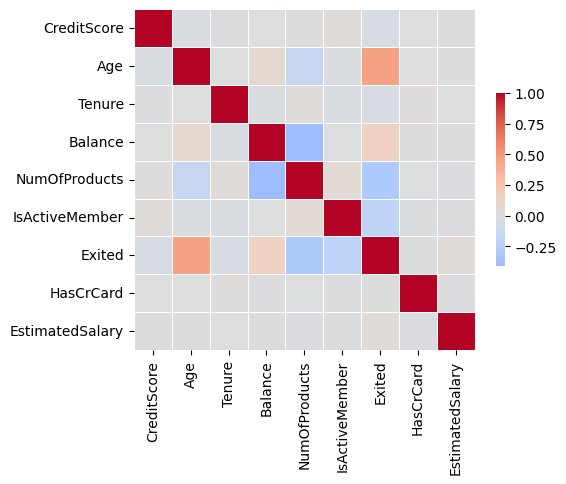

In [91]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import matplotlib.pyplot as plt

categorical_columns = ['Gender', 'Geography']
correlation_matrix = train_traitement.drop(columns=categorical_columns).corr()
distance_matrix = 2 * (1 - np.abs(correlation_matrix))
clustering = AgglomerativeClustering(n_clusters=3, linkage='single', metric="precomputed").fit(distance_matrix)
clusters = [list(correlation_matrix.columns[clustering.labels_ == lab]) for lab in set(clustering.labels_)]
reordered = np.concatenate(clusters)
R = correlation_matrix.loc[reordered, reordered]
f, ax = plt.subplots(figsize=(5.5, 4.5))
_ = sns.heatmap(R, cmap='coolwarm', vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

- Stratégie :
- soit enlève colonne Balance car elle est très corrélé avec Nombre de produit mais nombre de produit est plus corrélé avec la target que Balance
- soit on va laisser le modèle gérer le choix entre la variable Blance et NumOfPRODUCT

### Quelques graphiques d'exploration

In [92]:
# train_traitement.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,14923.000000,14923.000000,14923.000000,14923.000000,14923.000000,14923.000000,14923.000000,14923.000000,14923.000000
mean,658.637874,37.683576,5.039871,42898.277933,1.589493,0.779937,0.498425,117879.128325,0.200027
std,80.237665,8.112679,2.810855,59699.599647,0.532626,0.414303,0.500014,45591.495911,0.400034
min,431.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,602.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,82870.750000,0.000000
50%,661.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,123583.940000,0.000000
75%,708.500000,42.000000,7.000000,109846.705000,2.000000,1.000000,1.000000,157567.370000,0.000000
max,4818.000000,72.000000,10.000000,207034.960000,6.000000,1.000000,1.000000,199761.290000,1.000000


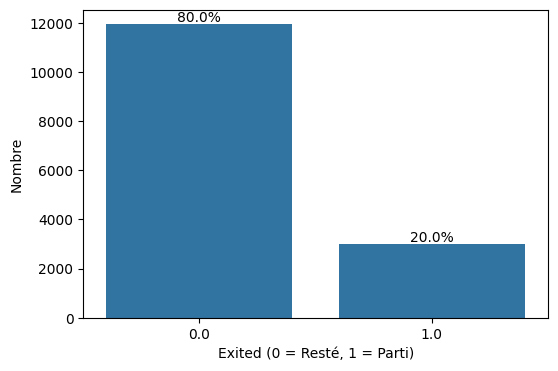

In [14]:
# # Distribution de la variable cible dans train_traitement 
# plt.figure(figsize=(6, 4))

# ax = sns.countplot(x='Exited', data=train_traitement)
# total = len(train_traitement)
# for p in ax.patches:
#     ax.annotate(f'{100 * p.get_height() / total:.1f}%', 
#                 (p.get_x() + p.get_width() / 2., p.get_height()), 
#                 ha='center', va='bottom')

# plt.xlabel('Exited (0 = Resté, 1 = Parti)')
# plt.ylabel('Nombre')
# plt.show()


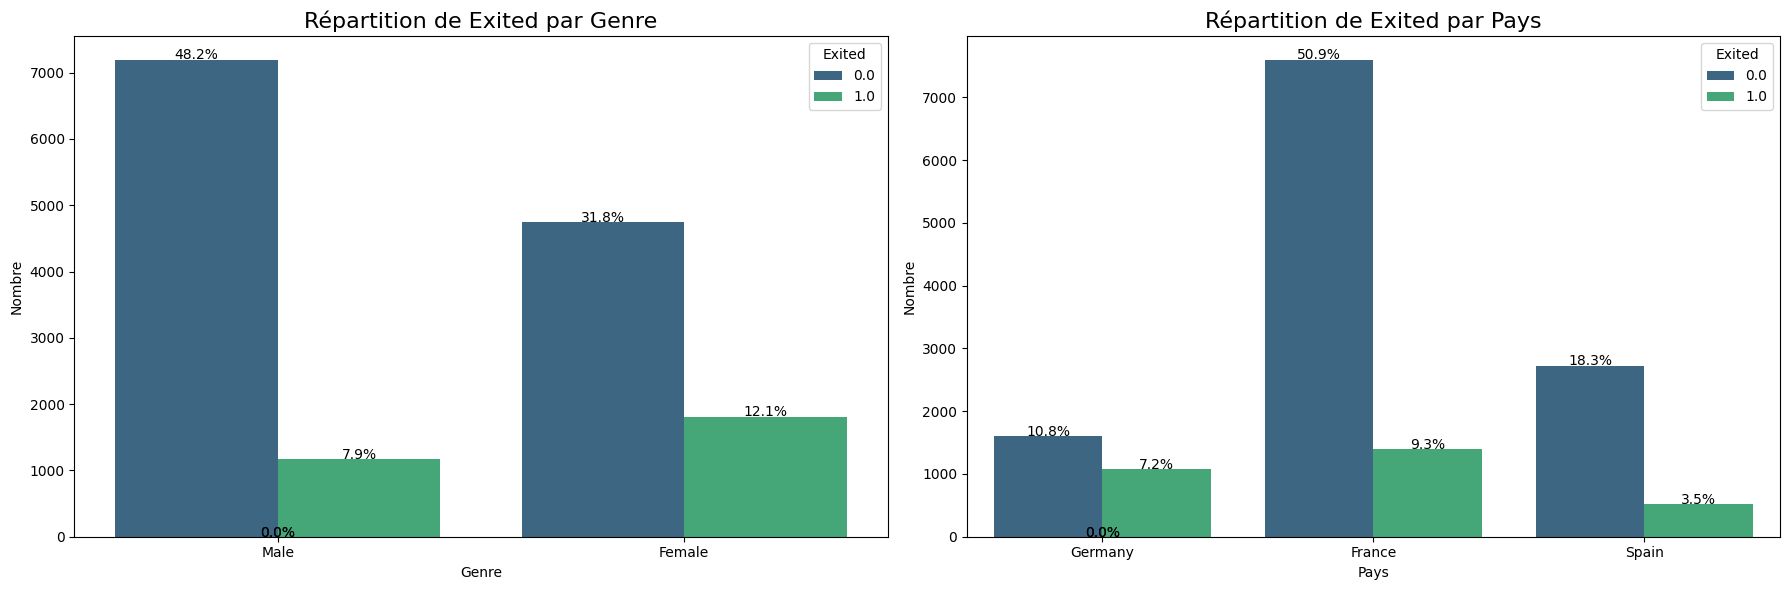

In [94]:
# colors = sns.color_palette('viridis', n_colors=2)
# fig, axes = plt.subplots(1, 2, figsize=(18, 6))
# total = len(train_traitement)

# # Graphique pour la variable Gender
# ax1 = sns.countplot(data=train_traitement, x='Gender', hue='Exited', ax=axes[0], palette=colors)
# for p in ax1.patches:
#     height = p.get_height()
#     ax1.text(
#         p.get_x() + p.get_width() / 2., 
#         height + 3, 
#         '{:1.1f}%'.format(100 * height / total), 
#         ha="center"
#     )
# ax1.set_title('Répartition de Exited par Genre', fontsize=16)
# ax1.set_xlabel('Genre', fontsize=10)
# ax1.set_ylabel('Nombre', fontsize=10)

# # Graphique pour la variable Geography
# ax2 = sns.countplot(data=train_traitement, x='Geography', hue='Exited', ax=axes[1], palette=colors)
# for p in ax2.patches:
#     height = p.get_height()
#     ax2.text(
#         p.get_x() + p.get_width() / 2., 
#         height + 3, 
#         '{:1.1f}%'.format(100 * height / total), 
#         ha="center"
#     )
# ax2.set_title('Répartition de Exited par Pays', fontsize=16)
# ax2.set_xlabel('Pays', fontsize=10)
# ax2.set_ylabel('Nombre', fontsize=10)

# plt.tight_layout()
# plt.show()


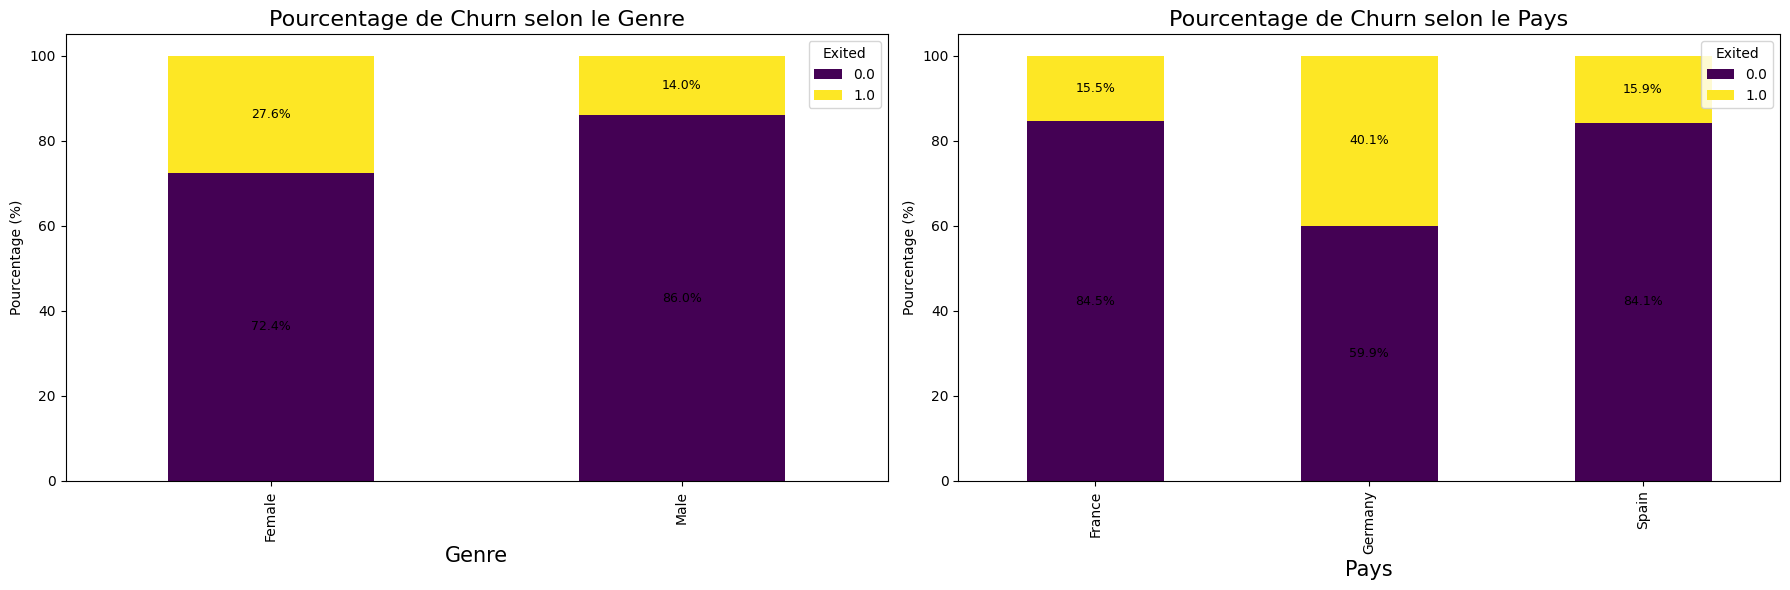

In [95]:
# colors = sns.color_palette('viridis', n_colors=2)
# fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# # Graphique pour la variable Gender
# gender_counts = train_traitement.groupby(['Gender', 'Exited']).size().unstack(fill_value=0)
# gender_percentage = gender_counts.div(gender_counts.sum(axis=1), axis=0) * 100

# ax1 = gender_percentage.plot(kind='bar', stacked=True, colormap='viridis', ax=axes[0])
# for container in ax1.containers:
#     ax1.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=9)
# ax1.set_title('Pourcentage de Churn selon le Genre', fontsize=16)
# ax1.set_xlabel('Genre', fontsize=15)
# ax1.set_ylabel('Pourcentage (%)')
# ax1.legend(title='Exited', loc='upper right')

# # Graphique pour la variable Geography
# geo_counts = train_traitement.groupby(['Geography', 'Exited']).size().unstack(fill_value=0)
# geo_percentage = geo_counts.div(geo_counts.sum(axis=1), axis=0) * 100

# ax2 = geo_percentage.plot(kind='bar', stacked=True, colormap='viridis', ax=axes[1])
# for container in ax2.containers:
#     ax2.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=9)
# ax2.set_title('Pourcentage de Churn selon le Pays', fontsize=16)
# ax2.set_xlabel('Pays', fontsize=15)
# ax2.set_ylabel('Pourcentage (%)')
# ax2.legend(title='Exited', loc='upper right')

# plt.tight_layout()
# plt.show()


Même si les femmes sont moins nombreuses que les hommes, elles ont tendance à churn plus que les hommmes.

In [96]:
# train_traitement['Tenure'].value_counts()
# table_tenure = pd.crosstab(train_traitement['Tenure'], train_traitement['Exited'])
# table_tenure

Exited,0.0,1.0
Tenure,,
0.0,318,109
1.0,1119,372
2.0,1398,300
3.0,1155,334
4.0,1292,292
5.0,1203,295
6.0,1134,318
7.0,1329,262
8.0,1299,285


In [97]:
# # Calcul des pourcentages par ligne
# table_tenure_percentage = table_tenure.div(table_tenure.sum(axis=1), axis=0) * 100


# table_tenure_reset = table_tenure.reset_index()
# table_tenure_melted = table_tenure_reset.melt(id_vars='Tenure', var_name='Exited', value_name='Count')
# table_tenure_percentage_reset = table_tenure_percentage.reset_index()
# table_tenure_percentage_melted = table_tenure_percentage_reset.melt(id_vars='Tenure', var_name='Exited', value_name='Percentage')
# table_tenure_melted['Percentage'] = table_tenure_percentage_melted['Percentage']

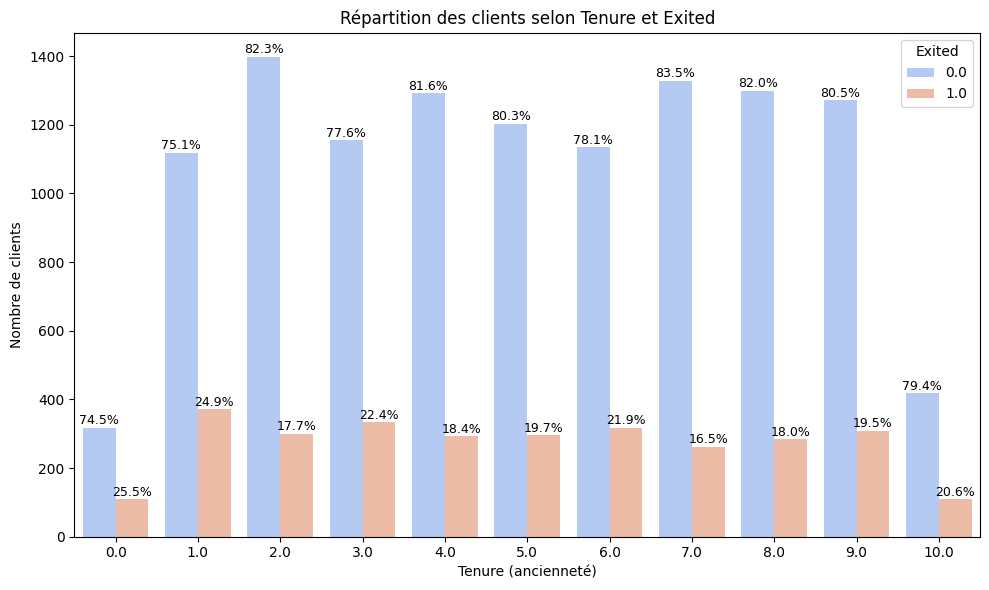

In [98]:
# # Barplot
# plt.figure(figsize=(10, 6))
# ax = sns.barplot(data=table_tenure_melted, x='Tenure', y='Count', hue='Exited', palette='coolwarm')

# table_tenure_melted = table_tenure_melted.reset_index(drop=True)  
# patch_index = 0  

# for i in range(len(table_tenure_melted)):
#     if patch_index < len(ax.patches):
#         bar = ax.patches[patch_index] 
#         height = bar.get_height()  
#         percentage = table_tenure_melted.iloc[i]['Percentage'] 

#         if height > 0:  
#             ax.text(
#                 bar.get_x() + bar.get_width() / 2,  
#                 height + 1,  
#                 f'{percentage:.1f}%',  
#                 ha='center', va='bottom', fontsize=9
#             )
#         patch_index += 1

# plt.title('Répartition des clients selon Tenure et Exited')
# plt.xlabel('Tenure (ancienneté)')
# plt.ylabel('Nombre de clients')
# plt.legend(title='Exited')
# plt.tight_layout()
# plt.show()

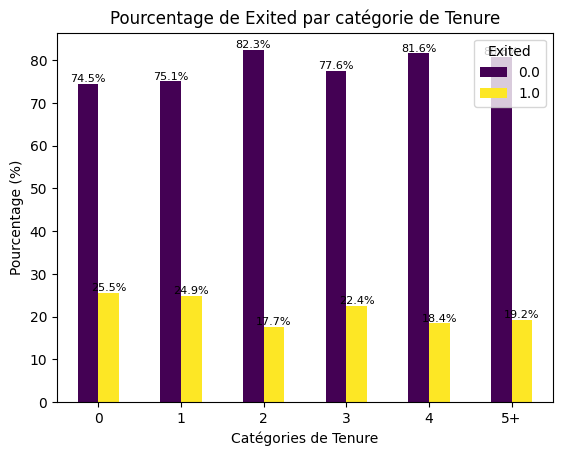

In [25]:
# # Fonction pour catégoriser selon les valeurs de Tenure
# def categorize_tenure(tenure):
#     if tenure == 0:
#         return '0'
#     elif tenure == 1:
#         return '1'
#     elif tenure == 2:
#         return '2'
#     elif tenure == 3:
#         return '3'
#     elif tenure == 4:
#         return '4'
#     else :
#         return '5+'


# train_traitement['Tenure_Category'] = train_traitement['Tenure'].apply(categorize_tenure)
# counts = train_traitement.groupby(['Tenure_Category', 'Exited']).size().unstack(fill_value=0)
# percentage = counts.div(counts.sum(axis=1), axis=0) * 100

# # Graphique
# ax = percentage.plot(kind='bar', colormap='viridis')
# plt.title('Pourcentage de Exited par catégorie de Tenure')
# plt.xlabel('Catégories de Tenure')
# plt.ylabel('Pourcentage (%)')


# for container in ax.containers:
#     ax.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=8)
# plt.xticks(rotation=0) 
# plt.legend(title='Exited', loc='upper right') 
# plt.show()


Probabilité de churn plus elevée lorsque le client est un nouvel arrivant ou peu récent

In [27]:
# table_products = pd.crosstab(train_traitement['NumOfProducts'], train_traitement['Exited'])
# table_products

Exited,0.0,1.0
NumOfProducts,,
1.0,3936,2459
2.0,7993,307
3.0,8,182
4.0,1,36
6.0,0,1


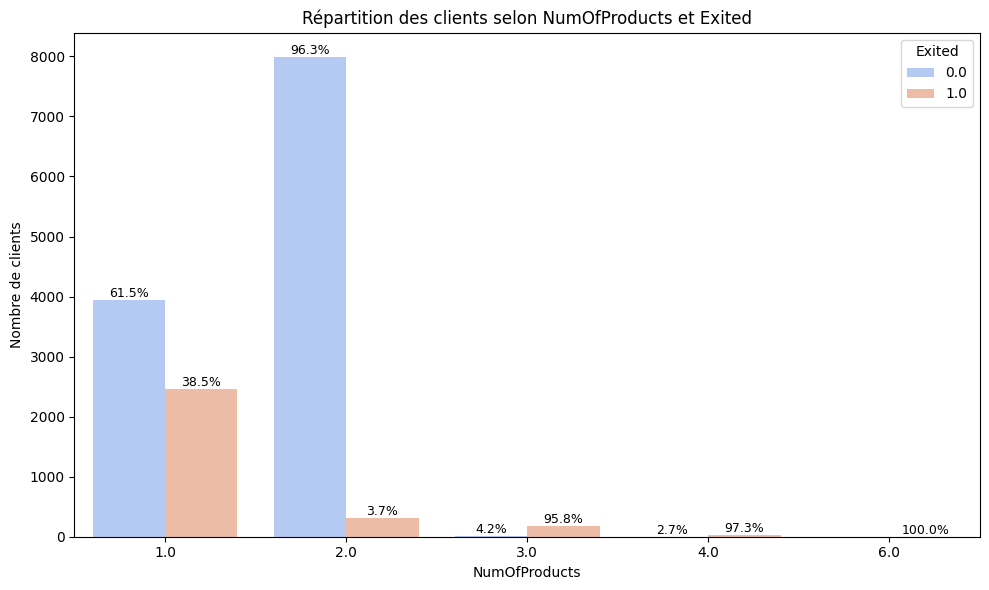

In [30]:
# table_products_percentage = table_products.div(table_products.sum(axis=1), axis=0) * 100
# table_products_reset = table_products.reset_index()
# table_products_melted = table_products_reset.melt(id_vars='NumOfProducts', var_name='Exited', value_name='Count')

# table_products_percentage_reset = table_products_percentage.reset_index()
# table_products_percentage_melted = table_products_percentage_reset.melt(
#     id_vars='NumOfProducts', var_name='Exited', value_name='Percentage'
# )
# table_products_melted['Percentage'] = table_products_percentage_melted['Percentage']

# plt.figure(figsize=(10, 6))
# ax = sns.barplot(data=table_products_melted, x='NumOfProducts', y='Count', hue='Exited', palette='coolwarm')
# table_products_melted = table_products_melted.reset_index(drop=True)
# patch_index = 0

# for i in range(len(table_products_melted)):
#     if patch_index < len(ax.patches):
#         bar = ax.patches[patch_index]
#         height = bar.get_height()
#         percentage = table_products_melted.iloc[i]['Percentage']
#         if height > 0:
#             ax.text(
#                 bar.get_x() + bar.get_width() / 2,
#                 height + 1,
#                 f'{percentage:.1f}%',
#                 ha='center', va='bottom', fontsize=9
#             )
#         patch_index += 1

# plt.title('Répartition des clients selon NumOfProducts et Exited')
# plt.xlabel('NumOfProducts')
# plt.ylabel('Nombre de clients')
# plt.legend(title='Exited')
# plt.tight_layout()
# plt.show()


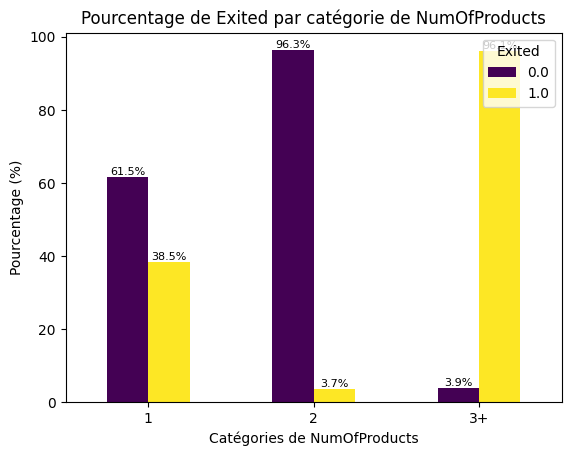

In [31]:
# def categorize_num_of_products(num_of_products):
#     if num_of_products == 1:
#         return '1'
#     elif num_of_products == 2:
#         return '2'
#     else:
#         return '3+'

# train_traitement['NumOfProducts_Category'] = train_traitement['NumOfProducts'].apply(categorize_num_of_products)
# counts = train_traitement.groupby(['NumOfProducts_Category', 'Exited']).size().unstack(fill_value=0)
# percentage = counts.div(counts.sum(axis=1), axis=0) * 100

# ax = percentage.plot(kind='bar', colormap='viridis')
# plt.title('Pourcentage de Exited par catégorie de NumOfProducts')
# plt.xlabel('Catégories de NumOfProducts')
# plt.ylabel('Pourcentage (%)')


# for container in ax.containers:
#     ax.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=8)
# plt.xticks(rotation=0) 
# plt.legend(title='Exited', loc='upper right') 

# plt.show()


Personnes ayant plus de 2 produits sont plus nombreuses, les clients ayant 1 ou +3 produits ont tendance à plus churn

In [32]:
# table_products = pd.crosstab(train_traitement['CreditScore'], train_traitement['Exited'])
# table_products

Exited,0.0,1.0
CreditScore,,
431.0,2,2
434.0,2,1
437.0,1,0
438.0,3,1
439.0,1,2
...,...,...
847.0,4,1
848.0,0,2
849.0,2,3


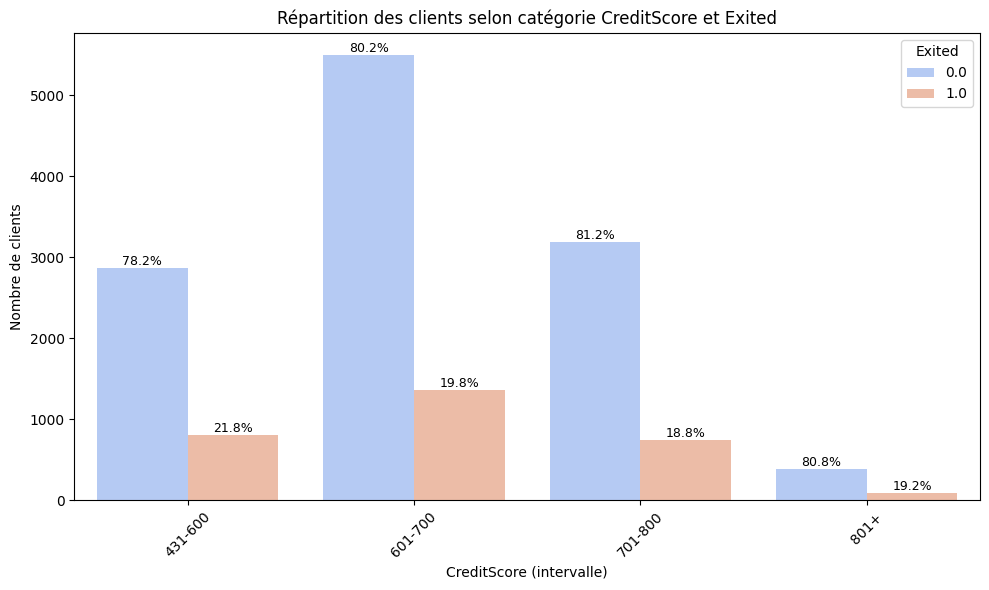

In [37]:
# # Diviser CreditScore en intervalles 
# bins = [431,600,700,800,4900]  
# labels = ['431-600','601-700','701-800','801+']  
# train_traitement['CreditScore_Binned'] = pd.cut(train_traitement['CreditScore'], bins=bins, labels=labels, right=False)


# table_credit_score = pd.crosstab(train_traitement['CreditScore_Binned'], train_traitement['Exited'])
# table_credit_score_percentage = table_credit_score.div(table_credit_score.sum(axis=1), axis=0) * 100

# table_credit_score_reset = table_credit_score.reset_index()
# table_credit_score_melted = table_credit_score_reset.melt(id_vars='CreditScore_Binned', var_name='Exited', value_name='Count')

# table_credit_score_percentage_reset = table_credit_score_percentage.reset_index()
# table_credit_score_percentage_melted = table_credit_score_percentage_reset.melt(
#     id_vars='CreditScore_Binned', var_name='Exited', value_name='Percentage'
# )
# table_credit_score_melted['Percentage'] = table_credit_score_percentage_melted['Percentage']


# plt.figure(figsize=(10, 6))
# ax = sns.barplot(data=table_credit_score_melted, x='CreditScore_Binned', y='Count', hue='Exited', palette='coolwarm')
# table_credit_score_melted = table_credit_score_melted.reset_index(drop=True)
# patch_index = 0  

# for i in range(len(table_credit_score_melted)):
#     if patch_index < len(ax.patches):
#         bar = ax.patches[patch_index] 
#         height = bar.get_height() 
#         percentage = table_credit_score_melted.iloc[i]['Percentage'] 

#         if height > 0:  
#             ax.text(
#                 bar.get_x() + bar.get_width() / 2,  
#                 height + 1,  
#                 f'{percentage:.1f}%',  
#                 ha='center', va='bottom', fontsize=9
#             )
#         patch_index += 1 

# plt.title('Répartition des clients selon catégorie CreditScore et Exited')
# plt.xlabel('CreditScore (intervalle)')
# plt.ylabel('Nombre de clients')
# plt.legend(title='Exited')
# plt.xticks(rotation=45)  
# plt.tight_layout()
# plt.show()


In [39]:
# category_counts = train_traitement['CreditScore_Binned'].value_counts()
# print(category_counts)


CreditScore_Binned
601-700    6853
701-800    3925
431-600    3666
801+        479
Name: count, dtype: int64


EstimatedSalary

In [63]:
# table_salary = pd.crosstab(train_traitement['EstimatedSalary'], train_traitement['Exited'])
# table_salary

Exited,0.0,1.0
EstimatedSalary,,
11.58,1,0
479.54,3,0
479.56,1,0
487.30,1,1
548.52,2,1
...,...,...
199661.50,0,1
199674.83,3,0
199693.84,1,0


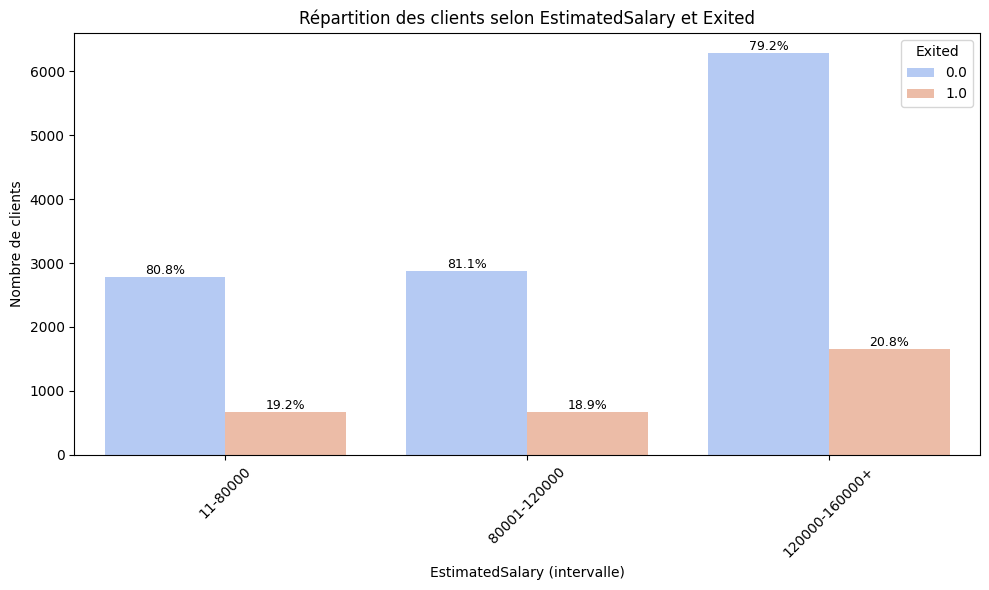

In [64]:
# bins = [11, 80000, 120000, 199761.29]
# labels = ['11-80000', '80001-120000', '120000-160000+']
# train_traitement['EstimatedSalary_Binned'] = pd.cut(train_traitement['EstimatedSalary'], bins=bins, labels=labels, right=False)

# table_salary = pd.crosstab(train_traitement['EstimatedSalary_Binned'], train_traitement['Exited'])
# table_salary_percentage = table_salary.div(table_salary.sum(axis=1), axis=0) * 100

# table_salary_reset = table_salary.reset_index()
# table_salary_melted = table_salary_reset.melt(id_vars='EstimatedSalary_Binned', var_name='Exited', value_name='Count')

# table_salary_percentage_reset = table_salary_percentage.reset_index()
# table_salary_percentage_melted = table_salary_percentage_reset.melt(
#     id_vars='EstimatedSalary_Binned', var_name='Exited', value_name='Percentage'
# )
# table_salary_melted['Percentage'] = table_salary_percentage_melted['Percentage']

# plt.figure(figsize=(10, 6))
# ax = sns.barplot(data=table_salary_melted, x='EstimatedSalary_Binned', y='Count', hue='Exited', palette='coolwarm')

# table_salary_melted = table_salary_melted.reset_index(drop=True)
# patch_index = 0

# for i in range(len(table_salary_melted)):
#     if patch_index < len(ax.patches):
#         bar = ax.patches[patch_index]
#         height = bar.get_height()
#         percentage = table_salary_melted.iloc[i]['Percentage']

#         if height > 0:
#             ax.text(
#                 bar.get_x() + bar.get_width() / 2,
#                 height + 1,
#                 f'{percentage:.1f}%',
#                 ha='center', va='bottom', fontsize=9
#             )
#         patch_index += 1

# plt.title('Répartition des clients selon EstimatedSalary et Exited')
# plt.xlabel('EstimatedSalary (intervalle)')
# plt.ylabel('Nombre de clients')
# plt.legend(title='Exited')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()


Assez similaire pour les 3 catégories

In [66]:
# category_counts = train_traitement['EstimatedSalary_Binned'].value_counts()
# print(category_counts)

EstimatedSalary_Binned
120000-160000+    7945
80001-120000      3535
11-80000          3442
Name: count, dtype: int64


AGE

In [67]:
# table_age = pd.crosstab(train_traitement['Age'], train_traitement['Exited'])

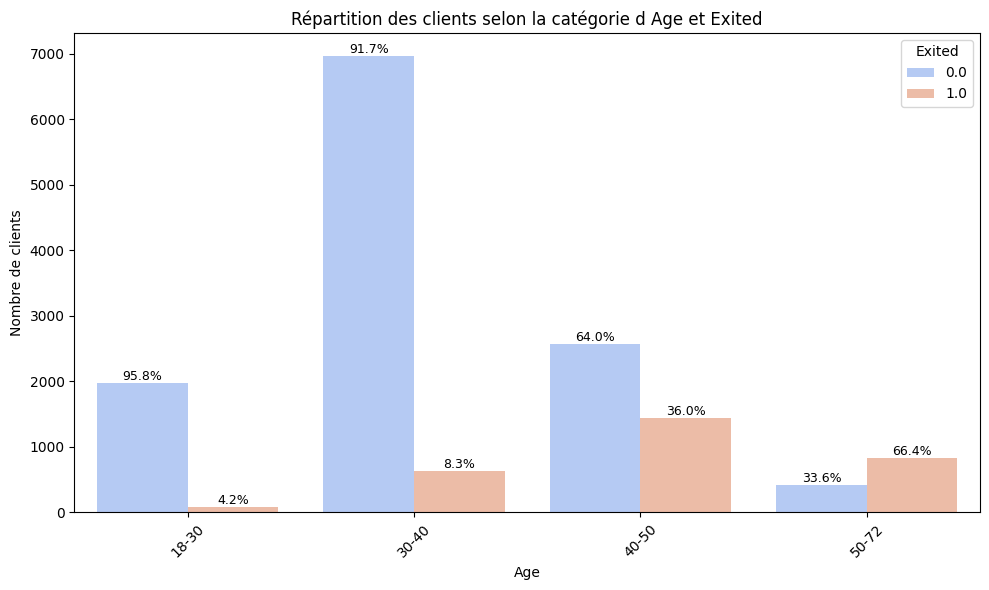

In [47]:
# bins = [18, 30, 40, 50, 72]
# labels = ['18-30', '30-40', '40-50', '50-72']
# train_traitement['Age_Binned'] = pd.cut(train_traitement['Age'], bins=bins, labels=labels, right=False)

# table_age = pd.crosstab(train_traitement['Age_Binned'], train_traitement['Exited'])
# table_age_percentage = table_age.div(table_age.sum(axis=1), axis=0) * 100

# table_age_reset = table_age.reset_index()
# table_age_melted = table_age_reset.melt(id_vars='Age_Binned', var_name='Exited', value_name='Count')

# table_age_percentage_reset = table_age_percentage.reset_index()
# table_age_percentage_melted = table_age_percentage_reset.melt(
#     id_vars='Age_Binned', var_name='Exited', value_name='Percentage'
# )
# table_age_melted['Percentage'] = table_age_percentage_melted['Percentage']

# plt.figure(figsize=(10, 6))
# ax = sns.barplot(data=table_age_melted, x='Age_Binned', y='Count', hue='Exited', palette='coolwarm')

# table_age_melted = table_age_melted.reset_index(drop=True)
# patch_index = 0

# for i in range(len(table_age_melted)):
#     if patch_index < len(ax.patches):
#         bar = ax.patches[patch_index]
#         height = bar.get_height()
#         percentage = table_age_melted.iloc[i]['Percentage']

#         if height > 0:
#             ax.text(
#                 bar.get_x() + bar.get_width() / 2,
#                 height + 1,
#                 f'{percentage:.1f}%',
#                 ha='center', va='bottom', fontsize=9
#             )
#         patch_index += 1

# plt.title('Répartition des clients selon la catégorie d Age et Exited')
# plt.xlabel('Age')
# plt.ylabel('Nombre de clients')
# plt.legend(title='Exited')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

Probabilité de churn semble plus elevée à partir de la catégorie 40-50

In [45]:
# category_counts = train_traitement['Age_Binned'].value_counts()
# print(category_counts)

Age_Binned
30-40    7598
40-50    4007
18-30    2064
50-72    1245
Name: count, dtype: int64


BALANCE

In [106]:
# table_balance = pd.crosstab(train_traitement['Balance'], train_traitement['Exited'])
# table_balance

Exited,0.0,1.0
Balance,,
0.00,8131,1537
51116.26,1,0
51522.75,1,0
51690.89,1,0
53573.18,0,1
...,...,...
186796.37,1,1
186825.57,1,0
187534.78,0,1


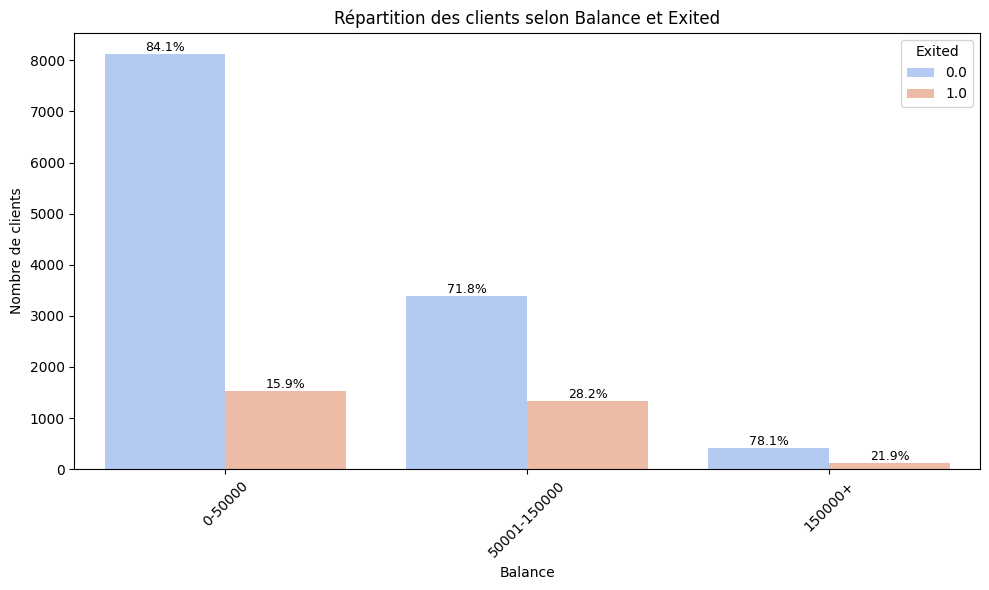

In [68]:
# bins = [0, 50000, 150000, 207034.96]
# labels = ['0-50000', '50001-150000','150000+']
# train_traitement['Balance_Binned'] = pd.cut(train_traitement['Balance'], bins=bins, labels=labels, right=False)

# table_balance = pd.crosstab(train_traitement['Balance_Binned'], train_traitement['Exited'])
# table_balance_percentage = table_balance.div(table_balance.sum(axis=1), axis=0) * 100

# table_balance_reset = table_balance.reset_index()
# table_balance_melted = table_balance_reset.melt(id_vars='Balance_Binned', var_name='Exited', value_name='Count')

# table_balance_percentage_reset = table_balance_percentage.reset_index()
# table_balance_percentage_melted = table_balance_percentage_reset.melt(
#     id_vars='Balance_Binned', var_name='Exited', value_name='Percentage'
# )
# table_balance_melted['Percentage'] = table_balance_percentage_melted['Percentage']

# plt.figure(figsize=(10, 6))
# ax = sns.barplot(data=table_balance_melted, x='Balance_Binned', y='Count', hue='Exited', palette='coolwarm')

# table_balance_melted = table_balance_melted.reset_index(drop=True)
# patch_index = 0

# for i in range(len(table_balance_melted)):
#     if patch_index < len(ax.patches):
#         bar = ax.patches[patch_index]
#         height = bar.get_height()
#         percentage = table_balance_melted.iloc[i]['Percentage']

#         if height > 0:
#             ax.text(
#                 bar.get_x() + bar.get_width() / 2,
#                 height + 1,
#                 f'{percentage:.1f}%',
#                 ha='center', va='bottom', fontsize=9
#             )
#         patch_index += 1

# plt.title('Répartition des clients selon Balance et Exited')
# plt.xlabel('Balance')
# plt.ylabel('Nombre de clients')
# plt.legend(title='Exited')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [58]:
# category_counts = train_traitement['Balance_Binned'].value_counts()
# print(category_counts)

Balance_Binned
0-50000         9668
50001-150000    4715
150000+          539
Name: count, dtype: int64


In [70]:
# train_traitement = train_traitement.drop(columns=['Tenure_Category','NumOfProducts_Category','CreditScore_Binned','Balance_Binned','EstimatedSalary_Binned','Age_Binned'])

#### Distribustion des variables continues

In [74]:
# col_numericals = ['CreditScore', 'Age','Tenure','Balance','NumOfProducts','EstimatedSalary']

In [75]:
# # Calcul la sk et la ku
# skewness = train_traitement[col_numericals].skew()
# kurtosis = train_traitement[col_numericals].kurt()

# print("Skewness:")
# print(skewness)
# print("\nKurtosis:")
# print(kurtosis)


Skewness:
CreditScore        9.356672
Age                0.814279
Tenure             0.005320
Balance            0.769502
NumOfProducts      0.178404
EstimatedSalary   -0.354464
dtype: float64

Kurtosis:
CreditScore        482.702489
Age                  1.109430
Tenure              -1.174981
Balance             -1.214840
NumOfProducts       -0.178782
EstimatedSalary     -0.735987
dtype: float64


####  Skewness
- CreditScore (9.356672) : Très fortement asymétrique vers la droite. Concentration des valeurs faibles et quelques valeurs très élevées.
- Age (0.814279) : Asymétrie modérée vers la droite càd plus de client 'jeune'.
- Tenure (0.005320) : Très proche de 0, ce qui indique une distribution quasi-symétrique.
- Balance (0.769502) : Faiblement asymétrique vers la droite. La plupart des clients ont un solde relativement faible (0), avec quelques valeurs élevées.
- NumOfProducts (0.178404) : Légèrement asymétrique vers la droite, mais proche de la symétrie.
- EstimatedSalary (-0.354464) : Faible asymétrie vers la gauche, avec une légère concentration des salaires plus élevés.

#### Kurtosis



- CreditScore (482.702489) : Kurtosis extrêmement élevée, indiquant une forte concentration autour de la moyenne avec des queues très longues ==> outliers marqués
- Age (1.109430) : Légèrement positive. Distribution modérément pointue avec des queues modérées.
- Tenure (-1.174981) : Kurtosis négative, suggérant une distribution plate et large avec peu de valeurs extrêmes.
- Balance (-1.214840) : Aplatissement similaire à celui de Tenure, reflétant une distribution étalée.
- NumOfProducts (-0.178782) : Proche de 0, indiquant une distribution équilibrée et proche de la normale.
- EstimatedSalary (-0.735987) : Assez étalée, avec une distribution relativement plate.

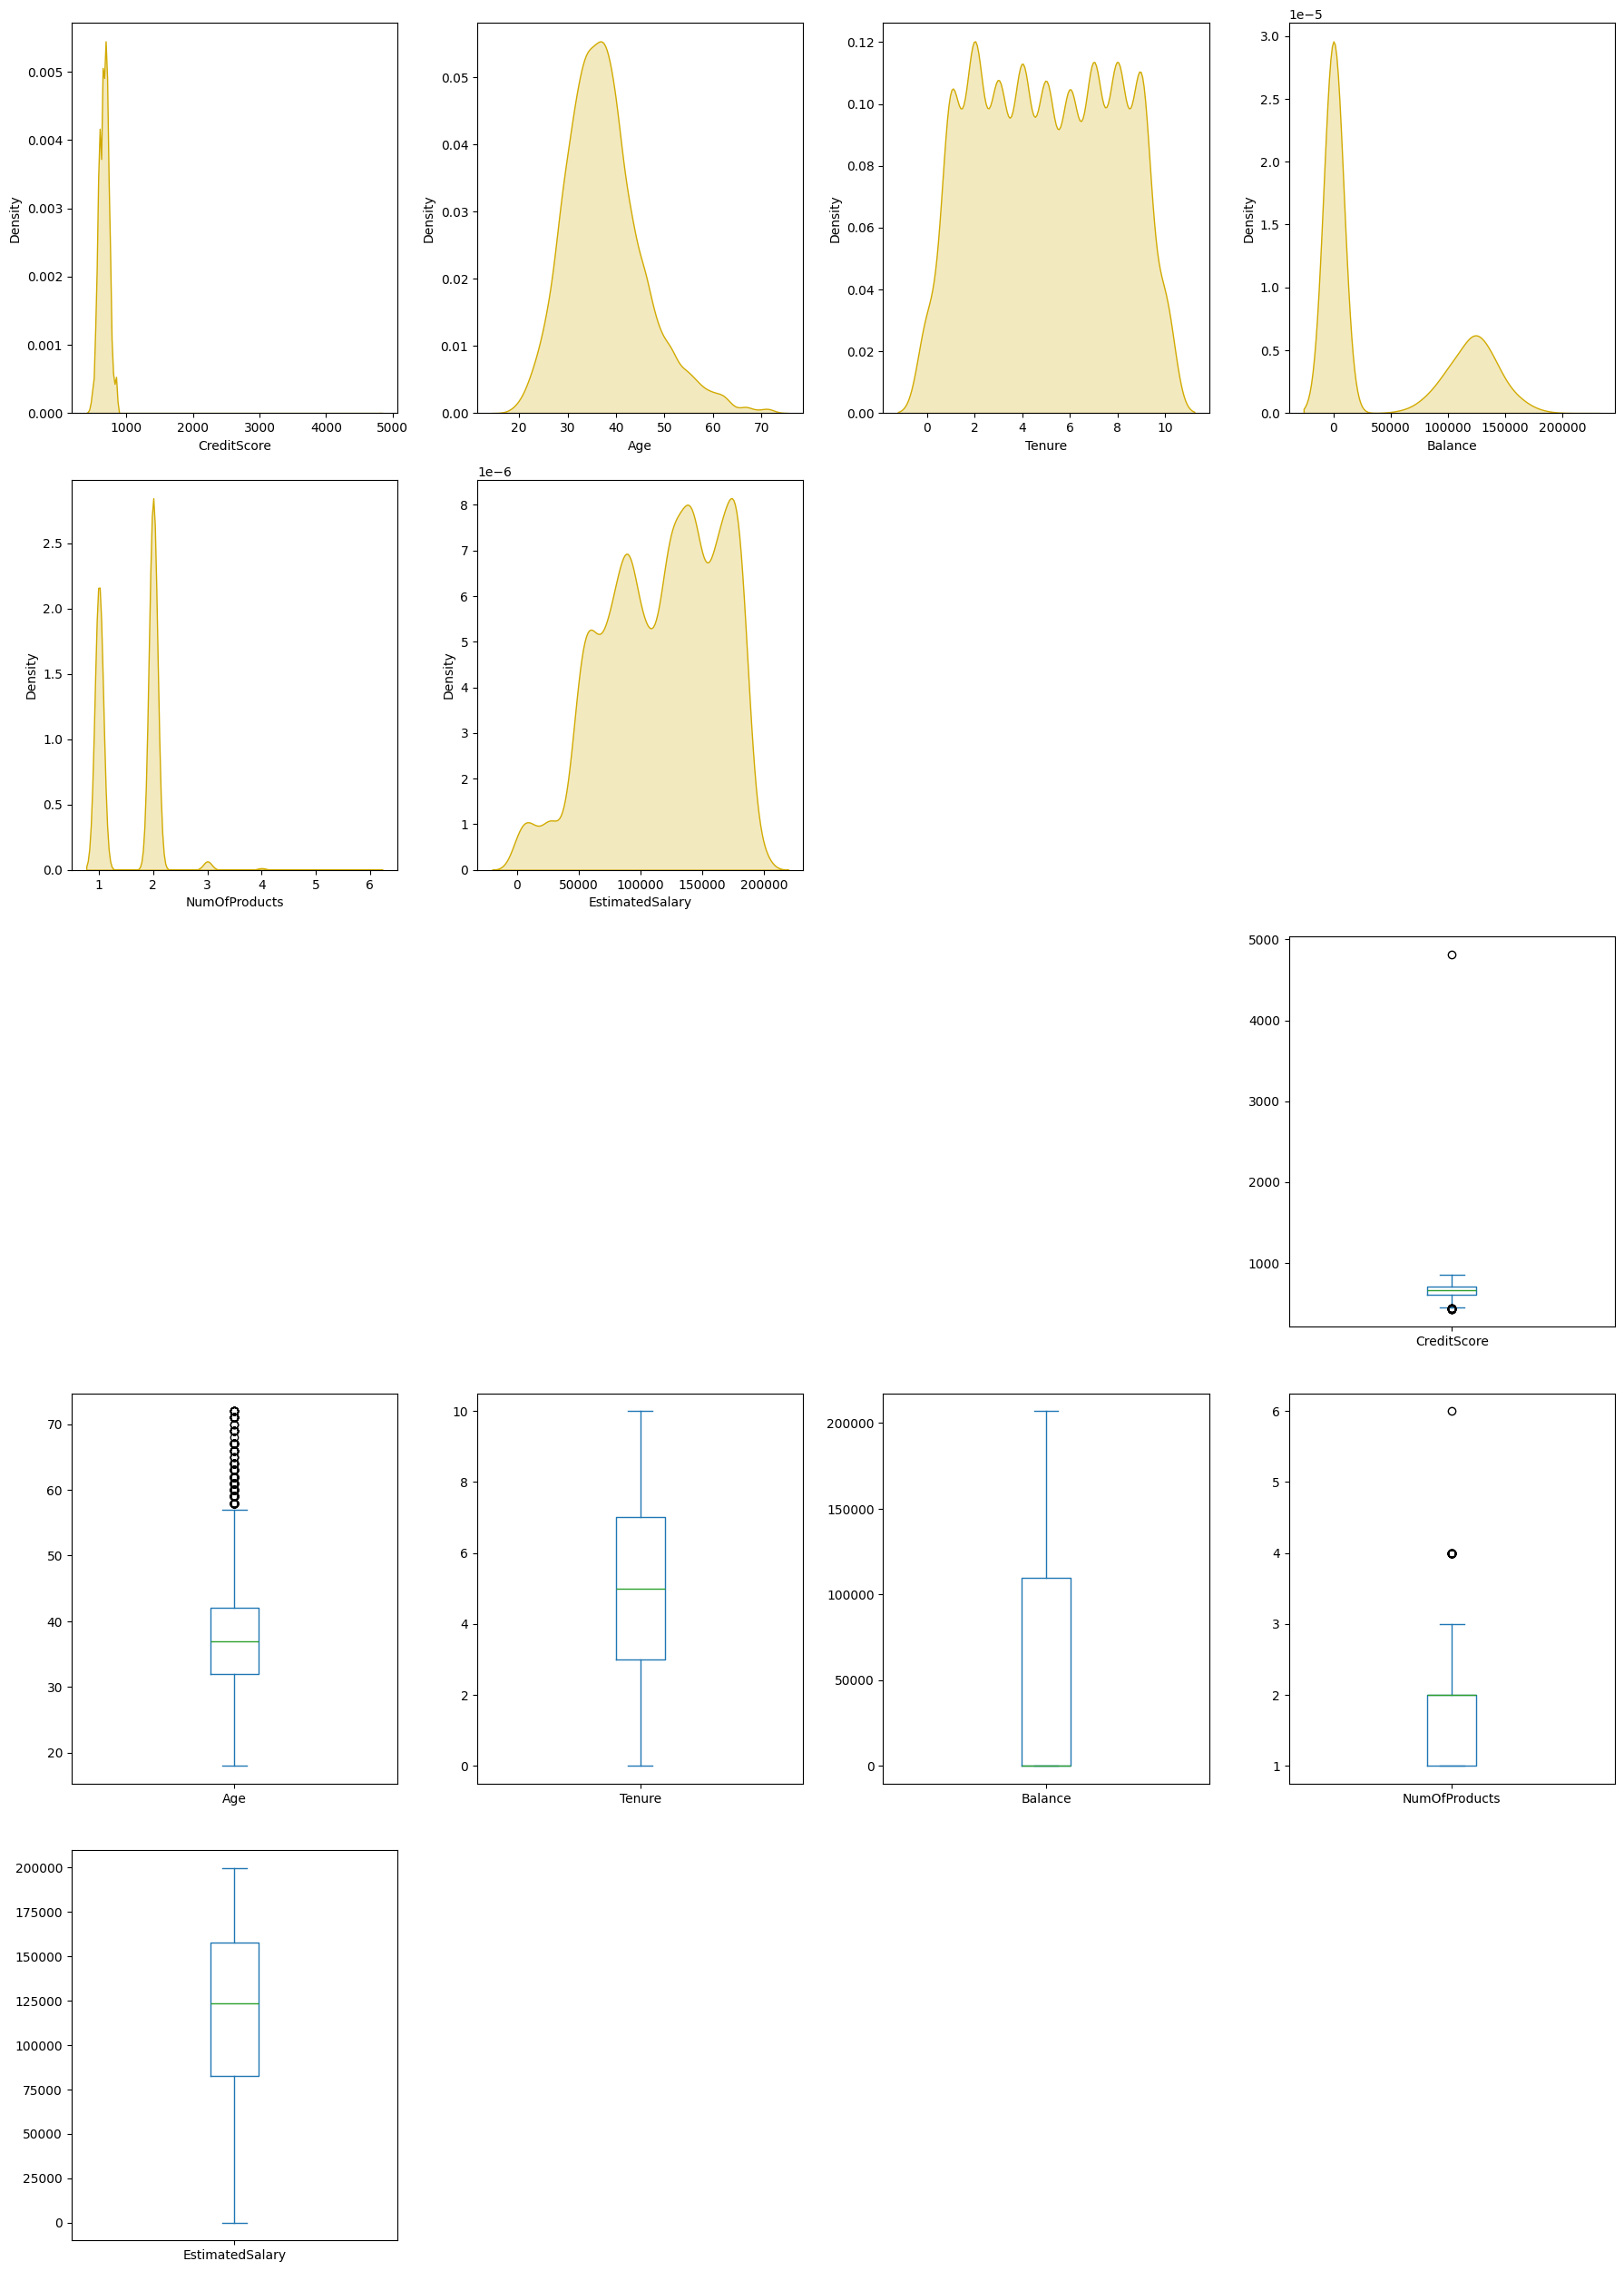

In [76]:
# Distribution et Box plot
plt.figure(figsize=(18,40))
for i,col in enumerate(col_numericals,1):
    plt.subplot(8,4,i)
    sns.kdeplot(train_traitement[col],color='#d1aa00',fill=True)
    plt.subplot(8,4,i+11)
    train_traitement[col].plot.box()
plt.tight_layout() 
plt.show()

### Outlier 

#### solution 1 (retenu) : distance de cook

Optimization terminated successfully.
         Current function value: 0.342150
         Iterations 7
Indices des outliers détectés : [    0    17    43 ... 14887 14894 14909]


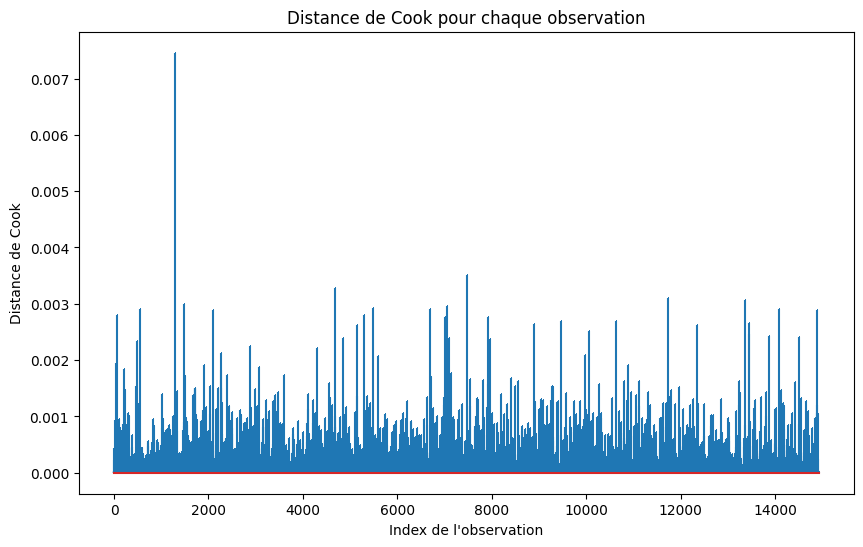

Nombre d'observations supprimées : 1245


In [101]:

class OutlierCooksDistance:
    def __init__(self, donnees: pd.DataFrame, variable_cible: str) -> None:
        self.donnees = donnees
        self.variable_cible = variable_cible
        self.colonnes_numeriques = donnees.select_dtypes(include=['float64', 'int64']).columns
        self.colonnes_categorielles = donnees.select_dtypes(include=['object']).columns
        self.variables_features = self.colonnes_numeriques.drop(variable_cible)
        self.X_features_numeriques = self.donnees[self.variables_features]
        self.y_cible = self.donnees[self.variable_cible]
        self.X_features_avec_constante = sm.add_constant(self.X_features_numeriques)

    def ajuster_modele_logistique(self):
        self.modele_logistique = sm.Logit(self.y_cible, self.X_features_avec_constante)
        self.modele_logistique_ajuste = self.modele_logistique.fit()

    def calculer_distances_cook(self):
        influence = self.modele_logistique_ajuste.get_influence()
        self.distances_cook = influence.cooks_distance[0]

    def identifier_outliers(self):
        nombre_observations = len(self.donnees)
        nombre_parametres = self.X_features_avec_constante.shape[1]
        seuil_distance_cook = 4 / (nombre_observations - nombre_parametres)
        self.outliers = np.where(self.distances_cook > seuil_distance_cook)[0]

    def supprimer_outliers(self) -> pd.DataFrame:
        if len(self.outliers) > 0:
            print(f"Indices des outliers détectés : {self.outliers}")
        # Utiliser errors='ignore' pour éviter les erreurs KeyError
            self.donnees_sans_outliers = self.donnees.drop(index=self.outliers, errors='ignore')
        else:
            print("Aucun outlier détecté. Pas de suppression d'observations.")
            self.donnees_sans_outliers = self.donnees
        return self.donnees_sans_outliers
    def tracer_distance_cook(self):
        plt.figure(figsize=(10, 6))
        plt.stem(np.arange(len(self.distances_cook)), self.distances_cook, markerfmt=",")
        plt.title("Distance de Cook pour chaque observation")
        plt.xlabel("Index de l'observation")
        plt.ylabel("Distance de Cook")
        plt.show()
data = train_traitement
variable_cible = 'Exited'
traitement = OutlierCooksDistance(data, variable_cible)

# Étapes de traitement
traitement.ajuster_modele_logistique()
traitement.calculer_distances_cook()
traitement.identifier_outliers()
data_train_sans_outlier = traitement.supprimer_outliers()
traitement.tracer_distance_cook()

# Affichage du nombre d'observations supprimées
print(f"Nombre d'observations supprimées : {len(train_traitement) - len(data_train_sans_outlier)}")


#### Solution 2 (non retenu): RobustScaler

In [32]:

# # Charger la table data_traitement
# # Remplacez "data_traitement.csv" par la source de vos données
# data = train_traitement

# # Initialiser le scaler
# scaler = RobustScaler()

# # Sélectionner les colonnes numériques pour le scaling
# numeric_cols = data.drop(columns=["Exited"]).select_dtypes(include=['float64', 'int64']).columns

# # Appliquer le scaling uniquement sur les colonnes numériques
# data_scaled = data.copy()
# data_scaled[numeric_cols] = scaler.fit_transform(data[numeric_cols])

# data_traitement = data_scaled

# import matplotlib.pyplot as plt
# import seaborn as sns

# # Comparaison avant et après scaling
# for col in numeric_cols:
#     plt.figure(figsize=(10, 4))
#     sns.kdeplot(data[col], label="Original", shade=True)
#     sns.kdeplot(data_scaled[col], label="Scaled", shade=True)
#     plt.title(f"Distribution de la colonne {col}")
#     plt.legend()
#     plt.show()


### Traitement catégorielles 

In [102]:
train_traitement = pd.get_dummies(train_traitement, columns=['Gender', 'Geography'], drop_first=False)*1
# pas de drop first sauf si on utilise la regression logistique

## Traitement table de test

In [103]:
test_traitement = test.drop(columns=['Surname', 'id', 'CustomerId'])
test_traitement = pd.get_dummies(test_traitement, columns=['Gender', 'Geography'], drop_first=False)*1

# 2. Modélisation <a class="anchor" id="Introduction"></a>
---


In [104]:
X = train_traitement.drop(columns=['Exited'])
y = train_traitement['Exited']

## 2.1 Modèle regression linéaire (non retenu) <a class="anchor" id="Introduction"></a>



In [518]:
# import statsmodels.api as sm

# X = train_traitement.drop(columns=['Exited'])
# y = train_traitement['Exited']
    
# # Add a constant to the model
# X = sm.add_constant(X)

# # Fit the logistic regression model
# logit_model = sm.Logit(y, X).fit()

# # Print the summary of the model
# print(logit_model.summary())



## 2.2 Modèle GradientBoosting <a class="anchor" id="Introduction"></a> (retenu, prédiction plus stable)



In [112]:
gbc = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                        learning_rate=0.1, loss='log_loss', max_depth=3,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        n_estimators=100, n_iter_no_change=None,
                        random_state=123, subsample=1.0, tol=0.0001,
                        validation_fraction=0.1, verbose=0,
                        warm_start=False)

#gbc.fit(X, y)

models = [gbc]
results = {}
for model in models:
    cv_results = cross_val_score(model, X, y, cv=StratifiedKFold(n_splits=5), scoring='roc_auc')
    results[model] = cv_results
    print(f'{model} - Mean AUC: {cv_results.mean()}')
    print(f'CV AUC scores: {cv_results}')


GradientBoostingClassifier(random_state=123) - Mean AUC: 0.9364528753918154
CV AUC scores: [0.93096485 0.94169059 0.94083623 0.93437127 0.93440144]


## 2.3 Modèle Ensembliste (non retenu)



In [170]:
# # Initialiser les modèles
# gbc = GradientBoostingClassifier(
#     ccp_alpha=0.0, criterion='friedman_mse', learning_rate=0.1, loss='log_loss',
#     max_depth=3, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0,
#     min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0,
#     n_estimators=100, random_state=123, subsample=1.0, tol=0.0001, verbose=0, warm_start=False
# )

# svc = SVC(probability=True, kernel='rbf', random_state=123)

# # VotingClassifier
# voting_clf = VotingClassifier(estimators=[('gbc', gbc), ('svc', svc)], voting='soft')

# # Évaluation croisée
# cv_results = cross_val_score(voting_clf, X, y, cv=StratifiedKFold(n_splits=5), scoring='roc_auc')

# print(f'VotingClassifier - Mean AUC: {cv_results.mean()}')
# print(f'CV AUC scores: {cv_results}')


VotingClassifier - Mean AUC: 0.9348369262004141
CV AUC scores: [0.92601618 0.94209672 0.94027508 0.9334755  0.93232115]


In [ ]:
# # Entraîner le modèle sur toutes les données d'entraînement
# voting_clf.fit(X, y)  # X et y sont vos données d'entraînement


In [174]:
# # Modele choisi
# model_choisi = voting_clf

# # Prédire les probabilités pour le jeu de test
# tester_predictions_proba = model_choisi.predict_proba(test_traitement)[:, 1]

# # Afficher les probabilités prédites
# print(tester_predictions_proba)

# # Créer un nouveau DataFrame avec 'id' et les prédictions
# tester_predictions_df = pd.DataFrame({'id': test['id'], 'Predictions': tester_predictions_proba})

# # Afficher le DataFrame créé
# print(tester_predictions_df.head())

# # Sauvegarder les prédictions dans un fichier CSV
# tester_predictions_df.to_csv('output/tester_predictions.csv', index=False)


[0.16333344 0.11857529 0.10873469 ... 0.10829393 0.1451094  0.26876138]
      id  Predictions
0  15000     0.163333
1  15001     0.118575
2  15002     0.108735
3  15003     0.414380
4  15004     0.118528


## 2.4 Modèle CatBoost (non retenu)


In [ ]:
# Initialiser le modèle CatBoostClassifier
"""""
catboost_model = CatBoostClassifier(
    iterations=100,               
    depth=3,                       
    learning_rate=0.1,             
    loss_function='Logloss',         
    random_state=123,              
    verbose=0                      
)


models = [catboost_model]
results = {}
for model in models:
    cv_results = cross_val_score(model, X, y, cv=StratifiedKFold(n_splits=5), scoring='roc_auc')
    # (pour éviter l'erreur "unhashable")
    model_key = f"CatBoost {model.get_params()['iterations']} it, {model.get_params()['depth']} depth"
    results[model_key] = cv_results
    
    print(f'{model_key} - Mean AUC: {cv_results.mean()}')
    print(f'CV AUC scores: {cv_results}')
    """"

CatBoost 100 it, 3 depth - Mean AUC: 0.9362405213634737
CV AUC scores: [0.93146112 0.94091549 0.93954698 0.9344239  0.93485512]


In [111]:
#print(f'Standard deviation of AUC scores: {cv_results.std()}')

Standard deviation of AUC scores: 0.0034885587520098143


## 2.5 Modèle ADAM (non retenu)



In [520]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.optimizers import Adam

# # Define the model
# model = Sequential()
# model.add(Dense(64, input_dim=X.shape[1], activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

# # Compile the model with Adam optimizer
# adam = Adam(learning_rate=0.1)  # Set learning_rate to 0.1 as specified
# model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

# # Train the model with mini-batch gradient descent
# model.fit(X, y, epochs=100, batch_size=32, validation_split=0.1, verbose=0)

# # Evaluate the model
# loss, accuracy = model.evaluate(X, y)
# print(f"Accuracy: {accuracy}")


# # Predict on the test set
# test_predictions = model.predict(test_traitement)
# print(test_predictions)

## 2.6.1 Modèle stacking simple  (retenu en deuxième choix, variance de l'AUC plus grande que gradient boosting)


In [ ]:
# stacking simple
base_learners = [
    ('gb', GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                                    learning_rate=0.1, loss='log_loss', max_depth=3,
                                    max_features=None, max_leaf_nodes=None,
                                    min_impurity_decrease=0.0, min_samples_leaf=1,
                                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                                    random_state=123, subsample=1.0, tol=0.0001,
                                    validation_fraction=0.1, verbose=0,
                                    warm_start=False)),
    ('lr', LogisticRegression(
        penalty='l2', solver='lbfgs', C=1.0, random_state=123, max_iter=10000
    )) ]

# Définir un meilleur modèle de meta
meta_model = LogisticRegression(max_iter=10000)

# Construire un modèle de stacking
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_model, cv=StratifiedKFold(n_splits=5))

# Entraîner le modèle
stacking_model.fit(X, y)

# Prédictions et évaluation
y_pred_stack = stacking_model.predict(X)
y_prob_stack = stacking_model.predict_proba(X)[:, 1]

# Calculer l'AUC
auc_stack = roc_auc_score(y, y_prob_stack)
print('AUC Stacking:', auc_stack)

# Afficher le classification report
print('Classification Report Stacking:')
print(classification_report(y, y_pred_stack))

# Cross-validation pour l'AUC avec StratifiedKFold
cv_auc_scores = cross_val_score(stacking_model, X, y, cv=StratifiedKFold(n_splits=5), scoring='roc_auc')
print(f'CV AUC scores: {cv_auc_scores}')
print(f'Mean AUC from CV: {np.mean(cv_auc_scores)}')


[LightGBM] [Info] Number of positive: 2985, number of negative: 11938
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 846
[LightGBM] [Info] Number of data points in the train set: 14923, number of used features: 13
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.11 MB) transferred to GPU in 0.001142 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200027 -> initscore=-1.386127
[LightGBM] [Info] Start training from score -1.386127
[LightGBM] [Info] Number of positive: 2388, number of negative: 9550
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 846
[LightGBM] [Info] Number of data points in the train set: 11938, number of used features: 13
[LightGBM] [Info] Using G

## 2.6.2 Stacking avec ElasticNet et des ensembles d'entrainement différents pour chaque learner



In [118]:
# stacking avec elastic net et des ensembles d'entrainement différent pour chaque learners
base_learners = [
    ('gb', GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                                    learning_rate=0.1, loss='log_loss', max_depth=3,
                                    max_features=None, max_leaf_nodes=None,
                                    min_impurity_decrease=0.0, min_samples_leaf=1,
                                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                                    random_state=123, subsample=1.0, tol=0.0001,
                                    validation_fraction=0.1, verbose=0,
                                    warm_start=False)),
('lr', LogisticRegression(
        penalty='l2', solver='lbfgs', C=1.0, random_state=123, max_iter=10000
    )) 
]

meta_model = ElasticNetCV(
    l1_ratio=[0.1, 0.5, 0.9], 
    alphas=np.logspace(-4, 1, 50),
    cv=5,
    random_state=123,
    max_iter=10000
)

# Stratégie K-fold
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)

meta_features = np.zeros((len(X), len(base_learners)))  # Matrice des caractéristiques méta

for train_idx, valid_idx in kf.split(X, y):
    if hasattr(X, "iloc"):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    else:
        X_train, X_valid = X[train_idx], X[valid_idx]
    
    if hasattr(y, "iloc"):
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    else:
        y_train, y_valid = y[train_idx], y[valid_idx]

    for i, (name, model) in enumerate(base_learners):
        cloned_model = clone(model)
        cloned_model.fit(X_train, y_train)  # Entraîner sur le pli d'entraînement
        meta_features[valid_idx, i] = cloned_model.predict_proba(X_valid)[:, 1]  # Stocker la probabilité de classe positive

meta_model.fit(meta_features, y)

final_meta_features = np.column_stack([
    model.fit(X, y).predict_proba(X)[:, 1] for name, model in base_learners
])  
y_pred_stack = (meta_model.predict(final_meta_features) > 0.5).astype(int)
y_prob_stack = meta_model.predict(final_meta_features)

auc_stack = roc_auc_score(y, y_prob_stack)
print('AUC Stacking:', auc_stack)

print('Classification Report Stacking:')
print(classification_report(y, y_pred_stack))

cv_auc_scores = []
for train_idx, valid_idx in kf.split(X, y):
    if hasattr(X, "iloc"):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    else:
        X_train, X_valid = X[train_idx], X[valid_idx]
    
    if hasattr(y, "iloc"):
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    else:
        y_train, y_valid = y[train_idx], y[valid_idx]

    for i, (name, model) in enumerate(base_learners):
        cloned_model = clone(model)
        cloned_model.fit(X_train, y_train)
        meta_features[valid_idx, i] = cloned_model.predict_proba(X_valid)[:, 1]
    
    meta_model.fit(meta_features[train_idx], y.iloc[train_idx] if hasattr(y, "iloc") else y[train_idx])
    y_valid_pred = meta_model.predict(meta_features[valid_idx])
    cv_auc_scores.append(roc_auc_score(y_valid, y_valid_pred))

print(f'CV AUC scores: {cv_auc_scores}')
print(f'Mean AUC from CV: {np.mean(cv_auc_scores)}')

/Users/maro/churn/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/maro/churn/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

AUC Stacking: 0.9438326383691508
Classification Report Stacking:
              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94     11938
         1.0       0.82      0.68      0.74      2985

    accuracy                           0.91     14923
   macro avg       0.87      0.82      0.84     14923
weighted avg       0.90      0.91      0.90     14923



/Users/maro/churn/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/maro/churn/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

CV AUC scores: [0.942041306476548, 0.9372701026068366, 0.9332305020355829, 0.929594909332306, 0.9401272526576466]
Mean AUC from CV: 0.936452814621784


/Users/maro/churn/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/maro/churn/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

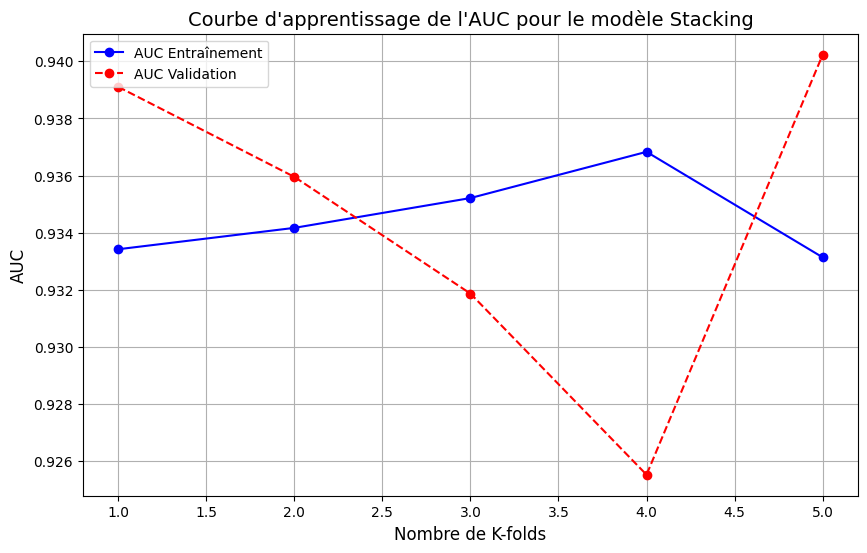

In [120]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Variables pour stocker les scores
train_auc_scores = []
valid_auc_scores = []

# Stratégie K-fold
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)

meta_features = np.zeros((len(X), len(base_learners)))  # Matrice des caractéristiques méta

# Effectuer les K-folds
for train_idx, valid_idx in kf.split(X, y):
    if hasattr(X, "iloc"):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    else:
        X_train, X_valid = X[train_idx], X[valid_idx]
    
    if hasattr(y, "iloc"):
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    else:
        y_train, y_valid = y[train_idx], y[valid_idx]

    # Entraîner les modèles de base et remplir la matrice des caractéristiques méta
    for i, (name, model) in enumerate(base_learners):
        cloned_model = clone(model)
        cloned_model.fit(X_train, y_train)  # Entraîner sur le pli d'entraînement
        meta_features[valid_idx, i] = cloned_model.predict_proba(X_valid)[:, 1]  # Stocker la probabilité de classe positive
    
    # Calculer l'AUC sur le jeu de validation pour ce pli
    y_train_pred_prob = np.column_stack([
        cloned_model.predict_proba(X_train)[:, 1] for _, cloned_model in base_learners
    ])
    y_valid_pred_prob = np.column_stack([
        cloned_model.predict_proba(X_valid)[:, 1] for _, cloned_model in base_learners
    ])

    # Calculer AUC pour l'entraînement et la validation
    train_auc = roc_auc_score(y_train, np.mean(y_train_pred_prob, axis=1))
    valid_auc = roc_auc_score(y_valid, np.mean(y_valid_pred_prob, axis=1))
    
    train_auc_scores.append(train_auc)
    valid_auc_scores.append(valid_auc)

# Tracer la courbe d'apprentissage de l'AUC
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_splits + 1), train_auc_scores, label='AUC Entraînement', marker='o', linestyle='-', color='b')
plt.plot(range(1, n_splits + 1), valid_auc_scores, label='AUC Validation', marker='o', linestyle='--', color='r')

plt.title('Courbe d\'apprentissage de l\'AUC pour le modèle Stacking', fontsize=14)
plt.xlabel('Nombre de K-folds', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


#   3. Explicabilité et métriques du modèle
---


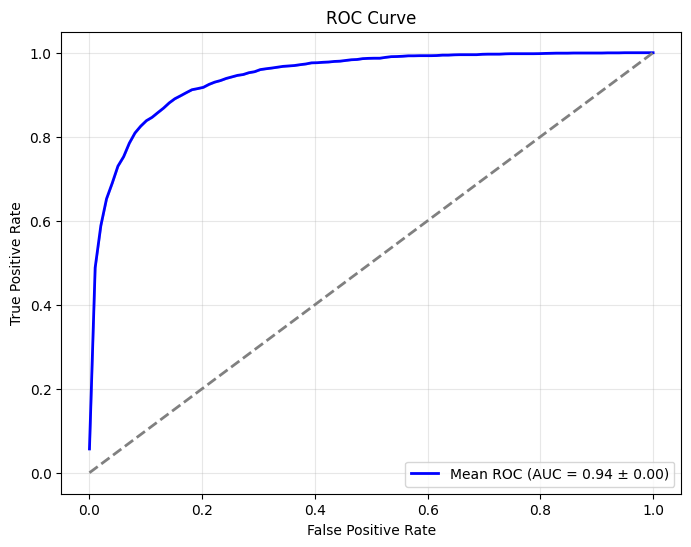

In [113]:
cv = StratifiedKFold(n_splits=5)
tprs = []
mean_fpr = np.linspace(0, 1, 100)
roc_auc_scores = []

for train, test in cv.split(X, y):
    gbc.fit(X, y)
    probas = gbc.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, probas)
    roc_auc = auc(fpr, tpr)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc_scores.append(roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(roc_auc_scores)

plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, color='b', label=f"Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})", lw=2)
plt.fill_between(mean_fpr, np.maximum(mean_tpr - np.std(tprs, axis=0), 0), 
                np.minimum(mean_tpr + np.std(tprs, axis=0), 1), color='blue', alpha=0.2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

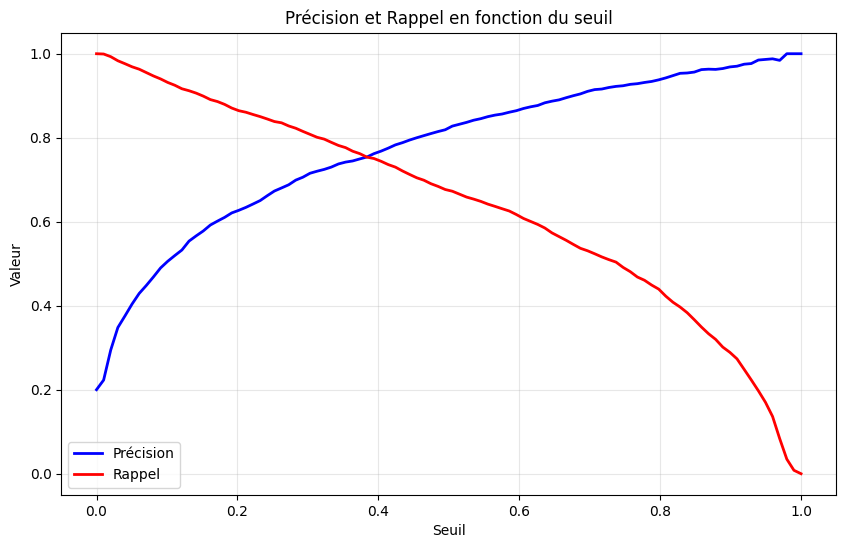

In [117]:
cv = StratifiedKFold(n_splits=5)
precision_list = []
recall_list = []
thresholds_list = []

for train, test in cv.split(X, y):
    gbc.fit(X, y)
    probas = gbc.predict_proba(X)[:, 1]
    
    # Calcul des courbes précision-rappel
    precision, recall, thresholds = precision_recall_curve(y, probas)
    
    # Ajustement des seuils pour correspondre aux dimensions
    thresholds = np.append(thresholds, 1.0)  # Ajouter un seuil pour correspondre à précision/rappel
    thresholds_list.append(thresholds)
    precision_list.append(precision)
    recall_list.append(recall)

# Moyenne sur les validations croisées
mean_thresholds = np.linspace(0, 1, 100)  # Créer des seuils uniformes pour interpolation
mean_precision = np.mean(np.vstack([np.interp(mean_thresholds, t, p) for t, p in zip(thresholds_list, precision_list)]), axis=0)
mean_recall = np.mean(np.vstack([np.interp(mean_thresholds, t, r) for t, r in zip(thresholds_list, recall_list)]), axis=0)

# Tracé des courbes
plt.figure(figsize=(10, 6))
plt.plot(mean_thresholds, mean_precision, label="Précision", color='blue', lw=2)
plt.plot(mean_thresholds, mean_recall, label="Rappel", color='red', lw=2)
plt.xlabel('Seuil')
plt.ylabel('Valeur')
plt.title('Précision et Rappel en fonction du seuil')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.show()


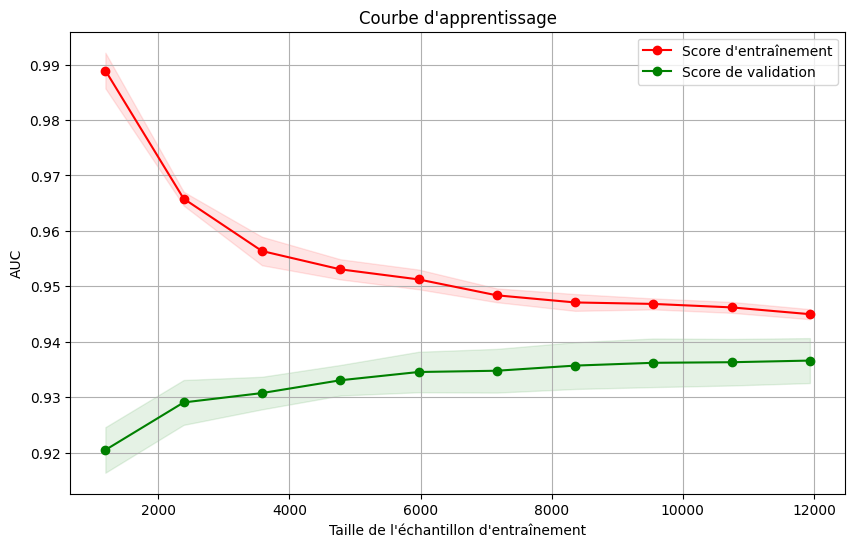

In [115]:
def plot_learning_curve(estimator, X, y, cv, scoring):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
    )
    
    # Moyenne et écart-type des scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Tracé du graphique
    plt.figure(figsize=(10, 6))
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score d'entraînement")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score de validation")

    plt.title("Courbe d'apprentissage")
    plt.xlabel("Taille de l'échantillon d'entraînement")
    plt.ylabel("AUC")
    plt.legend(loc="best")
    plt.show()

# Calcul de la courbe d'apprentissage
cv = StratifiedKFold(n_splits=5)
plot_learning_curve(gbc, X, y, cv=cv, scoring='roc_auc')


In [ ]:
#pip install shap

In [ ]:
# # Initialiser l'explainer SHAP
# import shap
# explainer = shap.Explainer(gbc, X)

# # Calculer les valeurs SHAP pour l'ensemble de test
# shap_values = explainer(test_traitement)

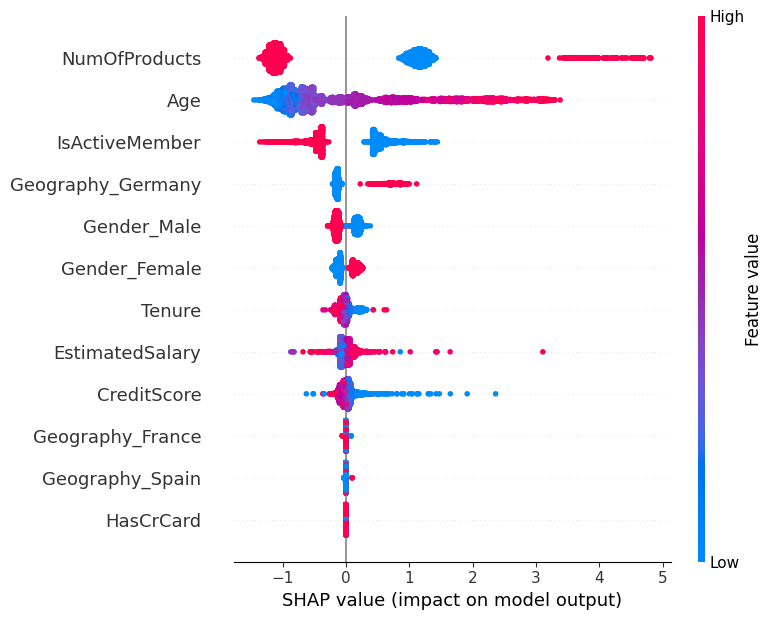

In [ ]:
# shap.summary_plot(shap_values, test_traitement)


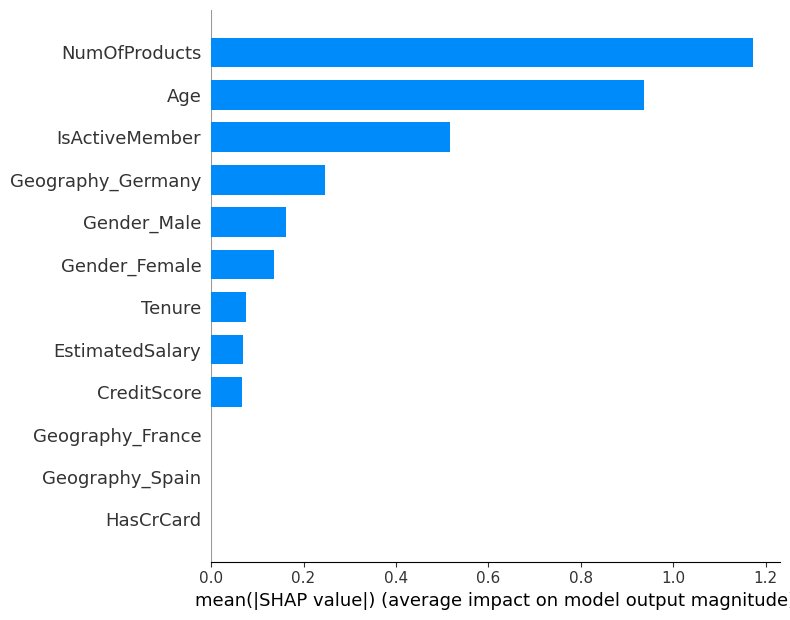

In [ ]:
# shap.summary_plot(shap_values, test_traitement, plot_type="bar")


Observation 1 (index 1109):


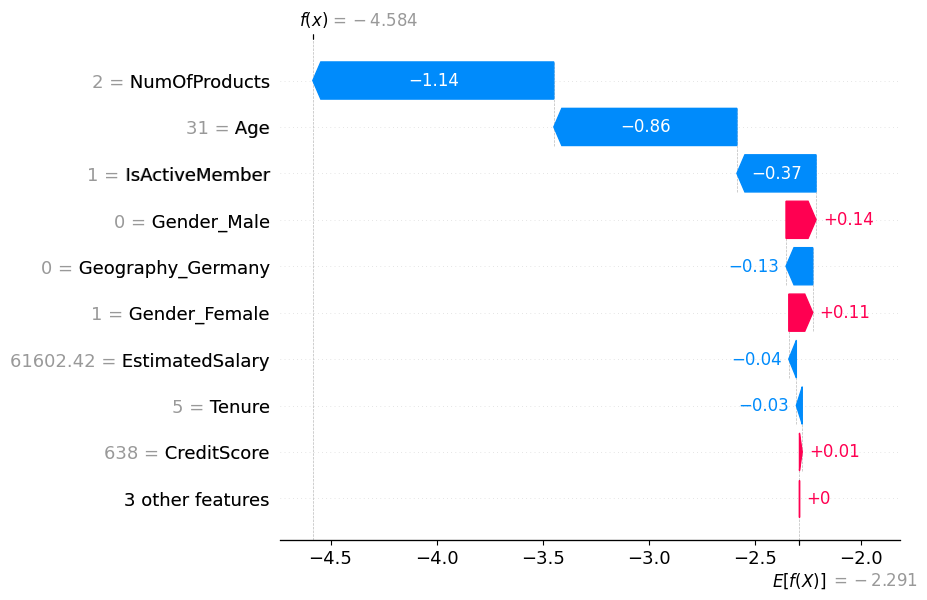

Observation 2 (index 7913):


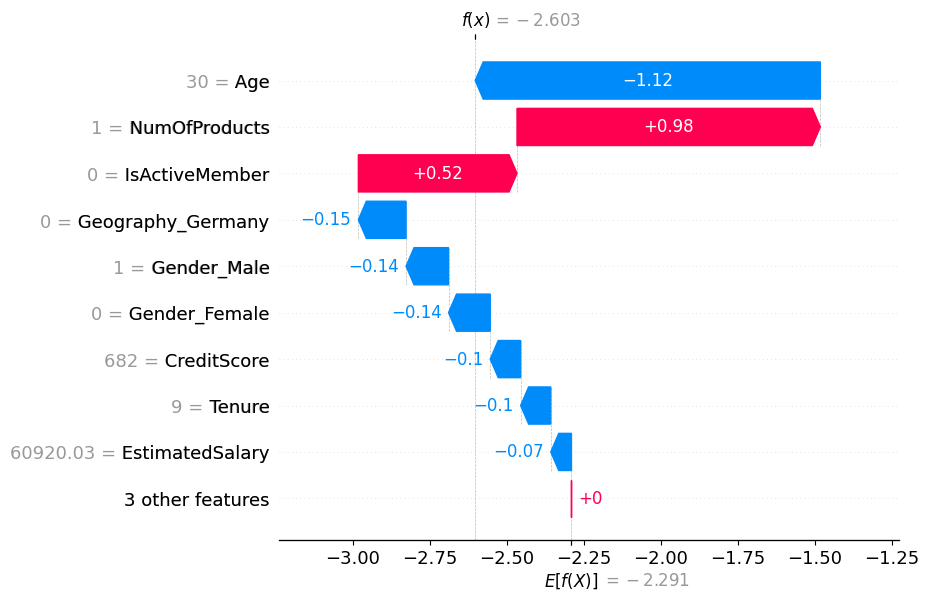

Observation 3 (index 612):


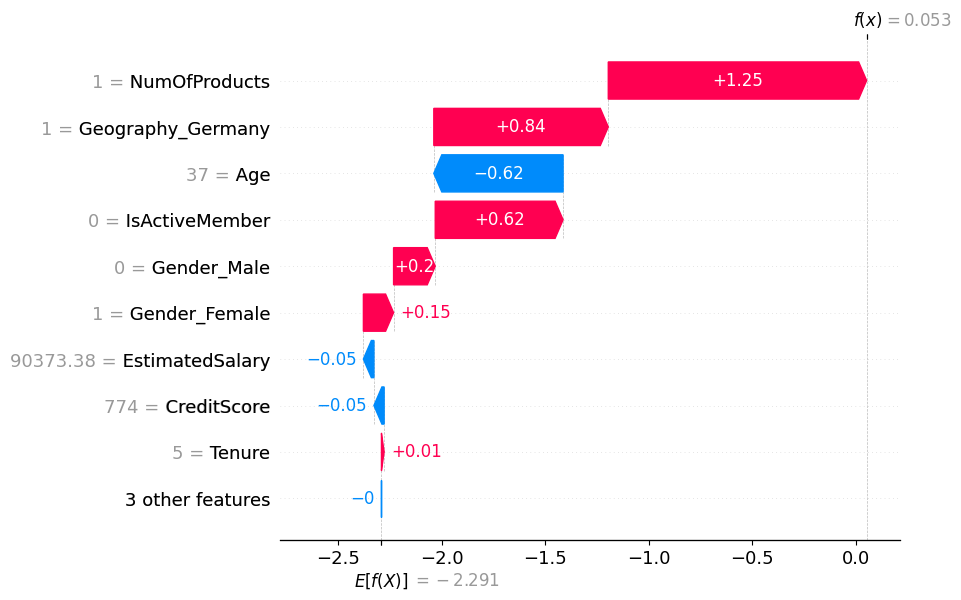

Observation 4 (index 1256):


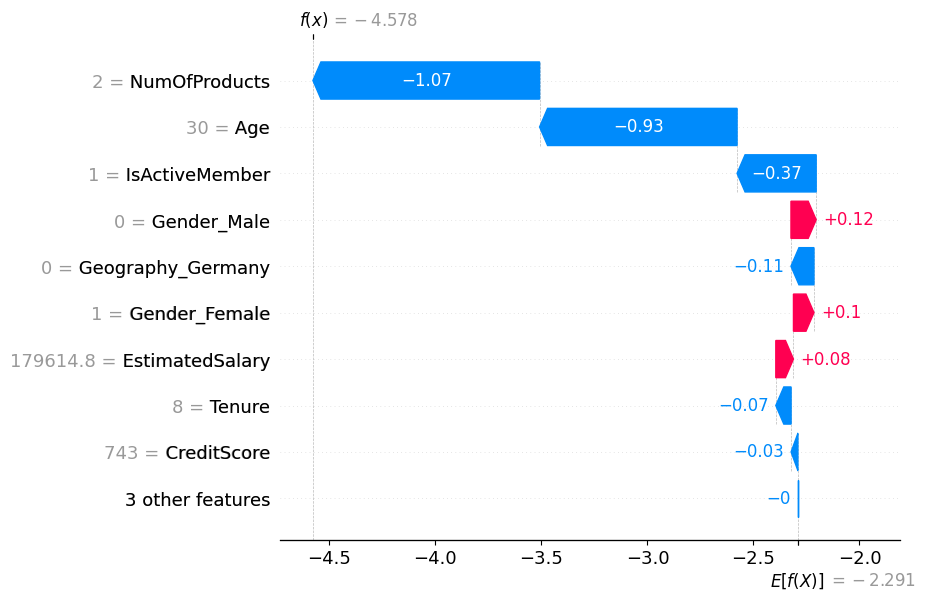

Observation 5 (index 4619):


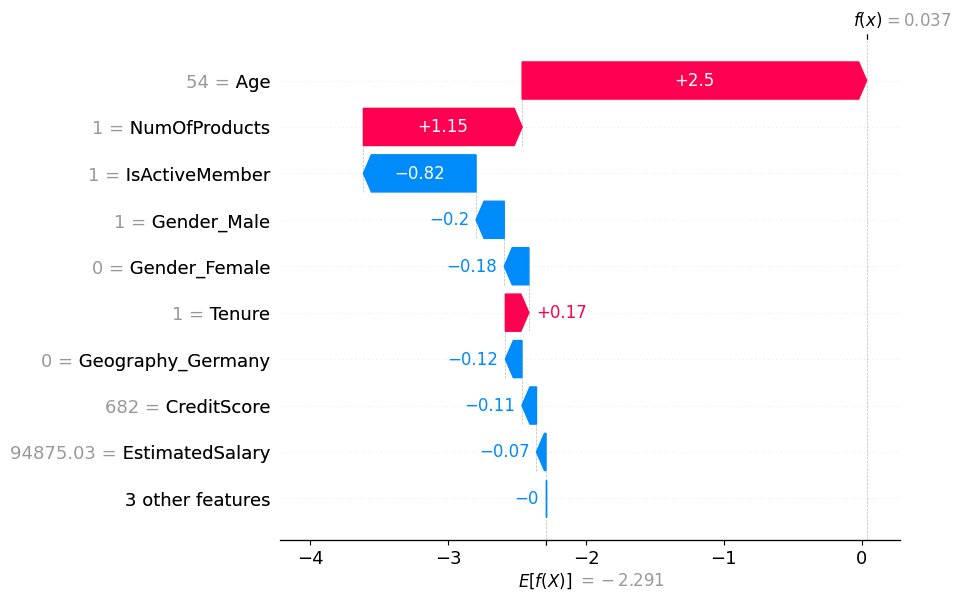

In [ ]:
# import random

# random_indices = random.sample(range(len(shap_values)), 5)

# # Générer les explications pour 5 observations
# for i, index in enumerate(random_indices):
#     print(f"Observation {i+1} (index {index}):")
#     shap.plots.waterfall(shap_values[index])

# 4. Prediction <a class="anchor" id="Introduction"></a>
---

## 4.1 Modèle gradient Boosting

In [50]:
# Modèle GB
modele_choisi = gbc
# Get the predicted probabilities
test_predictions_proba = modele_choisi.predict_proba(test_traitement)[:, 1]

# Display the predicted probabilities
print(test_predictions_proba)

# Create a new dataframe with 'id' and 'test_predictions'
test_predictions_df = pd.DataFrame({'id': test['id'], 'Predictions': test_predictions_proba})

# Display the new dataframe
print(test_predictions_df.head())
# Save the test_predictions_df to a CSV file
test_predictions_df.to_csv('output/test_predictions.csv', index=False)

[0.09846334 0.0213819  0.01509164 ... 0.01550868 0.0645109  0.39169937]
      id  Predictions
0  15000     0.098463
1  15001     0.021382
2  15002     0.015092
3  15003     0.626133
4  15004     0.040313


## 4.2 Modèle stacking

In [ ]:
# Modèle stacking
# if 'meta_model' in globals():  # Si le modèle final est basé sur le meta_model ElasticNet
#     # Générer les caractéristiques méta pour les données de test
#     test_meta_features = np.column_stack([
#         model.predict_proba(test_traitement)[:, 1] for name, model in base_learners
#     ])
#     test_predictions_proba = meta_model.predict(test_meta_features)
# else:  # Sinon, si un stacking_model a été utilisé (e.g., StackingClassifier)
#     test_predictions_proba = stacking_model.predict_proba(test_traitement)[:, 1]

# print("Probabilités prédites pour les données de test :")
# print(test_predictions_proba)

# test_predictions_df = pd.DataFrame({
#     'id': test['id'],  # Assurez-vous que 'id' est une colonne du DataFrame test
#     'Predictions': test_predictions_proba
# })

# print("Aperçu des prédictions :")
# print(test_predictions_df.head())

# Save the test_predictions_df to a CSV file
# test_predictions_df.to_csv('output/test_predictions.csv', index=False)


Probabilités prédites pour les données de test :
[0.09634415 0.01903829 0.0127418  ... 0.01316467 0.06232493 0.39064357]
Aperçu des prédictions :
      id  Predictions
0  15000     0.096344
1  15001     0.019038
2  15002     0.012742
3  15003     0.628387
4  15004     0.038094
